# Setup

In [1]:
from IPython.display import display

from brightway2 import *
import bw2analyzer as bwa
import brightway2 as bw
from bw2data.parameters import *
from lci_to_bw2 import *
from bw2data.project import ProjectManager
from bw2data.parameters import (ActivityParameter, DatabaseParameter,
                                ProjectParameter, Group)

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
# Directory with datasets:
ROOT_DIR = "files"

In [3]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [4]:
# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\IMG


In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [6]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [7]:
# List of the available projects
bw.projects

Brightway2 projects manager with 5 objects:
	LCA_Glazing
	LCA_Glazing_0
	LCOPT_Setup
	default
	test
Use `projects.report()` to get a report on all projects.

In [8]:
# New project or access an existing one:
bw.projects.set_current("LCA_Glazing")

# Where the current project is:
bw.projects.dir

'C:\\Users\\souvi\\AppData\\Local\\pylca\\Brightway3\\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab'

**Abbreviation:**

- fg = flat glass
- inv = inventory
- act = activity
- norm = normalised impacts
- ia = impact assessment
- fu = functional unit
- igu = insulating glass unit

# List of Scenarios with their Parameters

Import the Excel file with the LCA scenarios (i.e. the values for the parameters to be used in BW2 and EnergyPlus):

In [9]:
lca_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "lca_scenarios.xlsx"))

Define a series of dataframes for each step of calculation:

In [10]:
print("lca_scenarios, sheet names = \n {}\n".format(lca_scenarios.sheet_names))

lca_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16']



In [11]:
# Create dataframe for with scenarios for each step:
df_step1 = lca_scenarios.parse('Step1').set_index('name')
df_step2 = lca_scenarios.parse('Step2').set_index('name')
df_step3 = lca_scenarios.parse('Step3').set_index('name')
df_step4 = lca_scenarios.parse('Step4').set_index('name')
df_step5 = lca_scenarios.parse('Step5').set_index('name')
df_step6 = lca_scenarios.parse('Step6').set_index('name')
df_step7 = lca_scenarios.parse('Step7').set_index('name')
df_step8 = lca_scenarios.parse('Step8').set_index('name')
df_step9 = lca_scenarios.parse('Step9').set_index('name')
df_step10 = lca_scenarios.parse('Step10').set_index('name')
df_step11 = lca_scenarios.parse('Step11').set_index('name')
df_step12 = lca_scenarios.parse('Step12').set_index('name')
df_step13 = lca_scenarios.parse('Step13').set_index('name')
df_step14 = lca_scenarios.parse('Step14').set_index('name')
df_step15 = lca_scenarios.parse('Step15').set_index('name')
df_step16 = lca_scenarios.parse('Step16').set_index('name')

# Import of LCA Databases

In [12]:
# databases available in the current project:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

## Ecoinvent and Biosphere 3

**Importing Biosphere 3:**

In [13]:
# Importing elementary flows, LCIA methods and some other data
bw.bw2setup()

Biosphere database already present!!! No setup is needed


**Importing Ecoinvent 3.7, cut-off system model:**

For more information about the system models in ecoinvent 3, and especially the cut-off one, read [this](https://www.ecoinvent.org/database/system-models-in-ecoinvent-3/cut-off-system-model/allocation-cut-off-by-classification.html).

In [14]:
# Import ecoinvent 3.7 cut-off
ei37cutdir = r"C:\Users\souvi\Documents\These\80_Calculations\06_LCA_SystemDiagrams\02_Dataset\ecoinvent 3.7_cutoff_ecoSpold02\datasets"

if 'ecoinvent 3.7 cut-off' in databases:
    print("Database has already been imported!")
else:
    ei37cut = bw.SingleOutputEcospold2Importer(
        ei37cutdir, 'ecoinvent 3.7 cut-off')
    ei37cut.apply_strategies()
    ei37cut.statistics()
    ei37cut.write_database()

Database has already been imported!


## Excel Datasets

<font color='red'>Do we need to import the Excel datasets?<font>

In [15]:
import_exldb = False

**Importing the Excel dataset relating to aluminium production:**

In [16]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_alu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

**Importing the Excel dataset relating to silica sand production:**

In [17]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_silica_sand.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

**Importing the Excel dataset relating to IGUs:**

In [18]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_igu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_sand",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Add the project-level parameters:
    imp.write_project_parameters()

    # Write the data to a database to save it:
    imp.write_database()

**Importing the Excel dataset relating to double glazing w/ different types of spacers:**

In [19]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_spacers.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

**Importing the Excel dataset relating to curtain wall end-of-life phase:**

In [20]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw_eol.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

**Importing the Excel dataset relating to curtain wall production and use:**

In [21]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_cw_eol",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

**Checking if the imports went well:**

List databases:

In [22]:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

Checking Excel database:

**Deleting a database, if needed:**

## Navigate Databases

**Navigate Databases, assigning a variable to each one:**

In [23]:
eib3db = bw.Database('biosphere3')

eicutdb = bw.Database('ecoinvent 3.7 cut-off')

exldb_alu = bw.Database('exldb_alu')
exldb_igu = bw.Database('exldb_igu')
exldb_cw = bw.Database('exldb_cw')
exldb_spacers = bw.Database('exldb_spacers')
exldb_cw_eol = bw.Database('exldb_cw_eol')

# Define the Parameters

## Overview

**Checking the total number of parameters:**

In [24]:
len(parameters)

248

Look at the parameter directly:

In [25]:
print("Project parameters:")
for p in ProjectParameter.select():
    print(p.name, ":", round(p.amount, 2))

print("------")
print("Database parameters:")
for p in DatabaseParameter.select():
    print(p.database, " > ", p.name, ":", round(p.amount, 2))

print("------")
print("Activity parameters:")
for p in ActivityParameter.select():
    if "dummy" not in p.name:
        print(p.name, ":", round(p.amount, 2))

Project parameters:
param_g_density : 2.5
param_t_lsg : 10.0
param_t_tsg : 10.0
param_n_pvb : 2.0
param_d1 : 125.0
param_t_g_ext : 8.0
param_t_g_mid_tg : 6.0
param_t_g_uncoated_int : 8.0
------
Database parameters:
exldb_cw_eol  >  param_m_sg_g : 25.0
exldb_cw_eol  >  param_m_sg_alu : 3.31
exldb_cw_eol  >  param_m_sg_low_wood : 0.09
exldb_cw_eol  >  param_m_sg_low_silicone : 0.15
exldb_cw_eol  >  param_m_sg_high_epdm : 0.55
exldb_cw_eol  >  param_m_dg_g : 45.0
exldb_cw_eol  >  param_m_dg_alu : 3.47
exldb_cw_eol  >  param_m_dg_low_wood : 0.09
exldb_cw_eol  >  param_m_dg_low_silicone : 0.15
exldb_cw_eol  >  param_m_dg_high_epdm : 0.67
exldb_cw_eol  >  param_m_tg_g : 60.0
exldb_cw_eol  >  param_m_tg_alu : 3.79
exldb_cw_eol  >  param_m_tg_epdm : 0.78
exldb_cw_eol  >  param_m_ccf_g : 70.0
exldb_cw_eol  >  param_m_ccf_alu : 13.22
exldb_cw_eol  >  param_m_ccf_epdm : 1.95
exldb_cw_eol  >  param_m_vacuum_g : 45.0
exldb_cw_eol  >  param_m_smart_g : 45.0
exldb_cw_eol  >  param_m_smart_elec : 0.94

## Activate Parameters

**We have now to tell bw to activate the exchanges and their formulas:**

First, we tell the parameter code that these exchanges have formulas:

In [26]:
# Add exchanges with formulas from activity to group:
for act in exldb_igu:
    parameters.add_exchanges_to_group("igu_param_group", act)

In [27]:
ls_act_data_cw_eol = []
n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw_eol"):
    ls_act_data_cw_eol.append({'name': obj.name, 'amount': obj.amount,
                               'formula': obj.formula, 'database': obj.database,
                              'code': "p_eol_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw_eol, "cw_eol_param_group", overwrite=True)

In [28]:
for act in exldb_cw_eol:
    parameters.add_exchanges_to_group("cw_eol_param_group", act)

In [29]:
ls_act_data_cw = []
n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw"):
    ls_act_data_cw.append({'name': obj.name, 'amount': obj.amount,
                           'formula': obj.formula, 'database': obj.database,
                           'code': "p_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw, "cw_use_param_group", overwrite=True)

In [30]:
for act in exldb_cw:
    parameters.add_exchanges_to_group("cw_use_param_group", act)

Then we calculate the "activated" formula values:

In [31]:
ActivityParameter.recalculate_exchanges("igu_param_group")
ActivityParameter.recalculate_exchanges("cw_use_param_group")
ActivityParameter.recalculate_exchanges("cw_eol_param_group")

**Delete the parameters:**

# LCIA Methods

List of available LCIA methods:

Define methods:

In [32]:
method_ilcd_gwp = (
    'ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

In [33]:
methods_small = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

In [34]:
methods_full = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

# LCA of Glass Sheets and IGUs from Cradle to Gate

## Flat Glass Production

Define the <font color='red'> functional unit </font> per flat glass (fg) type:

In [35]:
inv_fg_unsorted = [act for act in exldb_igu
                   if 'market for flat glass' in act['name']
                   ]

inv_fg = sorted(inv_fg_unsorted,
                key=lambda k: k['name'])

inv_fg

['market for flat glass, coated' (kilogram, BE, ('building components', 'windows')),
 'market for flat glass, uncoated' (kilogram, BE, ('building components', 'windows'))]

In [36]:
names_fg_processed = ['market for laminated safety glass',
                      'market for tempered safety glass',
                      'market for smart glass'
                      ]

inv_fg_processed_unsorted = [act for act in exldb_igu
                             for n in names_fg_processed
                             if n in act['name']
                             and "glazing" not in act['name']
                             ]

inv_fg_processed = sorted(inv_fg_processed_unsorted,
                          key=lambda k: k['name'])

inv_fg_processed

['market for laminated safety glass' (square meter, BE, ('building components', 'windows')),
 'market for laminated safety glass, coated' (square meter, BE, ('building components', 'windows')),
 'market for smart glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass, coated' (square meter, BE, ('building components', 'windows'))]

In [37]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

impacts_fg = []

for act in inv_fg:
    lca = bw.LCA({act: fu_fg})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

for act in inv_fg_processed:
    lca = bw.LCA({act: fu_fg_processed})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

# impacts_fg

In [38]:
df_impacts_fg = pd.DataFrame(impacts_fg, columns=["Name", "Location", "Method",
                                                  "Score", "Unit"])

df_impacts_fg = pd.pivot_table(df_impacts_fg, index=["Name"],
                               columns=["Method", "Unit"],
                               values="Score")

In [39]:
df_impacts_fg = df_impacts_fg.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

df_impacts_fg.round(2)

Method                                    Climate Change Ecosystem Quality  \
Unit                                           kg CO2-Eq               CTU   
Name                                                                         
market for flat glass, uncoated                    27.11              7.08   
market for flat glass, coated                      28.71              9.15   
market for tempered safety glass                   29.22              7.31   
market for tempered safety glass, coated           30.86              9.41   
market for laminated safety glass                  36.93             12.35   
market for laminated safety glass, coated          37.75             13.40   
market for smart glass                            542.85           1338.69   

Method                                                                \
Unit                                      kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                   
market for flat glass, uncoated              0.00      0.22     0.60   
market for flat glass, coated                0.00      0.24     0.63   
market for tempered safety glass             0.00      0.23     0.62   
market for tempered safety glass, coated     0.00      0.24     0.65   
market for laminated safety glass            0.01      0.26     0.69   
market for laminated safety glass, coated    0.01      0.27     0.70   
market for smart glass                       0.04      2.27     7.39   

Method                                    Human Health            Resources  \
Unit                                        kg CFC-11. kg NMVOC-. megajoule   
Name                                                                          
market for flat glass, uncoated                    0.0       0.14    344.41   
market for flat glass, coated                      0.0       0.15    377.57   
market for tempered safety glass                   0.0       0.15    377.22   
market for tempered safety glass, coated           0.0       0.15    411.04   
market for laminated safety glass                  0.0       0.17    623.93   
market for laminated safety glass, coated          0.0       0.17    640.85   
market for smart glass                             0.0       2.21   8464.07   

Method                                              
Unit                                        points  
Name                                                
market for flat glass, uncoated             104.18  
market for flat glass, coated               146.02  
market for tempered safety glass            106.57  
market for tempered safety glass, coated    149.25  
market for laminated safety glass           196.82  
market for laminated safety glass, coated   218.16  
market for smart glass                     7881.78

In [40]:
df_impacts_fg = df_impacts_fg.reset_index()
df_impacts_fg['Name'] = (df_impacts_fg['Name']
                         .str.replace('market for ', ''))

df_impacts_fg = df_impacts_fg.set_index('Name')

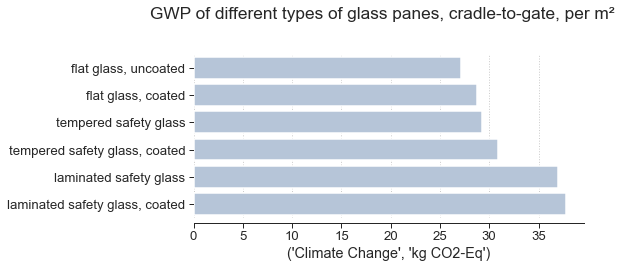

In [41]:
fig, ax = plt.subplots(figsize=(7, 3))

df_impacts_wo_smartg = df_impacts_fg.drop("smart glass", axis=0)

sns.barplot(data=df_impacts_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_wo_smartg.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, per m²', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [42]:
df_norm_impacts_wo_smartg = (
    df_impacts_wo_smartg / df_impacts_wo_smartg.max()
)
df_norm_impacts_wo_smartg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.72              0.53    0.47   
flat glass, coated                       0.76              0.68    0.59   
tempered safety glass                    0.77              0.55    0.48   
tempered safety glass, coated            0.82              0.70    0.60   
laminated safety glass                   0.98              0.92    0.94   
laminated safety glass, coated           1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.84     0.86         0.49       0.83   
flat glass, coated                  0.89     0.90         0.51       0.88   
tempered safety glass               0.86     0.88         0.54       0.86   
tempered safety glass, coated       0.91     0.92         0.56       0.90   
laminated safety glass              0.97     0.98         0.99       0.98   
laminated safety glass, coated      1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.54   0.48  
flat glass, coated                  0.59   0.67  
tempered safety glass               0.59   0.49  
tempered safety glass, coated       0.64   0.68  
laminated safety glass              0.97   0.90  
laminated safety glass, coated      1.00   1.00

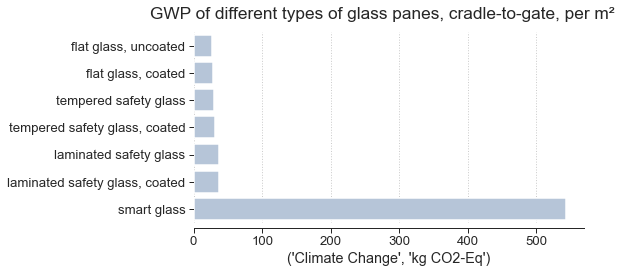

In [43]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sns.barplot(data=df_impacts_fg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_fg.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [44]:
df_norm_impacts_fg = df_impacts_fg / df_impacts_fg.max()
df_norm_impacts_fg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.05              0.01    0.06   
flat glass, coated                       0.05              0.01    0.07   
tempered safety glass                    0.05              0.01    0.06   
tempered safety glass, coated            0.06              0.01    0.08   
laminated safety glass                   0.07              0.01    0.12   
laminated safety glass, coated           0.07              0.01    0.13   
smart glass                              1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.10     0.08         0.02       0.06   
flat glass, coated                  0.10     0.09         0.02       0.07   
tempered safety glass               0.10     0.08         0.02       0.07   
tempered safety glass, coated       0.11     0.09         0.03       0.07   
laminated safety glass              0.11     0.09         0.04       0.08   
laminated safety glass, coated      0.12     0.10         0.04       0.08   
smart glass                         1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.04   0.01  
flat glass, coated                  0.04   0.02  
tempered safety glass               0.04   0.01  
tempered safety glass, coated       0.05   0.02  
laminated safety glass              0.07   0.02  
laminated safety glass, coated      0.08   0.03  
smart glass                         1.00   1.00

**Same calculation, but using the MultiLCA class:**

In [45]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

mlca_syst_fg = []

for act in inv_fg:
    mlca_syst_fg.append({act.key: fu_fg})

for act in inv_fg_processed:
    mlca_syst_fg.append({act.key: fu_fg_processed})

mlca_syst_fg

[{('exldb_igu', 'market_glass_coated'): 25},
 {('exldb_igu', 'market_glass_uncoated'): 25},
 {('exldb_igu', 'market_lsg'): 1},
 {('exldb_igu', 'market_lsg_coated'): 1},
 {('exldb_igu', 'market_smartglass'): 1},
 {('exldb_igu', 'market_tsg'): 1},
 {('exldb_igu', 'market_tsg_coated'): 1}]

In [46]:
bw.calculation_setups['calculation_setup'] = {'inv': mlca_syst_fg,
                                              'ia': methods_small}

mlca = bw.MultiLCA('calculation_setup')
df_impacts_mlca_fg = pd.DataFrame(data=mlca.results, columns=mlca.methods)

In [47]:
activities = [(get_activity(key), amount)
              for dct in mlca.func_units
              for key, amount in dct.items()
              ]

df_fu = pd.DataFrame([(x['name'], x['database'], x['code'],
                       x['location'], x['unit'], y)
                      for x, y in activities],
                     columns=('Database', 'Code', 'Name',
                              'Location', 'Unit', 'Amount')
                     )

df_impacts_mlca_fg_expanded = pd.concat(
    [df_fu, df_impacts_mlca_fg], axis=1
)

In [48]:
df_impacts_mlca_fg_expanded = (
    df_impacts_mlca_fg_expanded.set_index("Name")
    .drop(["Database", "Code", "Location"], axis=1).round(2)
)

In [49]:
df_impacts_mlca_fg_expanded.sort_values(
    by=[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')],
    ascending=True)

,Unit,Amount,"(ILCD 2.0 2018 midpoint, climate change, climate change total)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater ecotoxicity)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater and terrestrial acidification)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, terrestrial eutrophication)","(ILCD 2.0 2018 midpoint, human health, ozone layer depletion)","(ILCD 2.0 2018 midpoint, human health, photochemical ozone creation)","(ILCD 2.0 2018 midpoint, resources, fossils)","(ILCD 2.0 2018 midpoint, resources, land use)"
Name,,,,,,,,,,,
market_glass_uncoated,kilogram,25,27.11,7.08,0.22,0.00,0.60,0.0,0.14,344.41,104.18
market_glass_coated,kilogram,25,28.71,9.15,0.24,0.00,0.63,0.0,0.15,377.57,146.02
market_tsg,square meter,1,29.22,7.31,0.23,0.00,0.62,0.0,0.15,377.22,106.57
market_tsg_coated,square meter,1,30.86,9.41,0.24,0.00,0.65,0.0,0.15,411.04,149.25
market_lsg,square meter,1,36.93,12.35,0.26,0.01,0.69,0.0,0.17,623.93,196.82
market_lsg_coated,square meter,1,37.75,13.40,0.27,0.01,0.70,0.0,0.17,640.85,218.16
market_smartglass,square meter,1,542.85,1338.69,2.27,0.04,7.39,0.0,2.21,8464.07,7881.78


## Impact of Different Types of Spacers, Sealants and Insulating Gases, Cradle-to-Gate

**Comparative analysis of different spacers:**

In [50]:
inv_spacers = [act for act in bw.Database("exldb_spacers")
               if 'krypton' not in act['name']
               and 'xenon' not in act['name']
               and 'air' not in act['name']]

fu_spacers = [{igu: 1} for igu in inv_spacers]

In [51]:
impacts_spacers = []

for igu in inv_spacers:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_spacers.append((igu["name"], igu["location"],
                                method[1].title(), lca.score,
                                bw.methods.get(method).get('unit')))

# impacts_spacers

In [52]:
df_impacts_spacers = pd.DataFrame(
    impacts_spacers,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_spacers = pd.pivot_table(
    df_impacts_spacers, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [53]:
df_impacts_spacers = df_impacts_spacers.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_spacers = df_impacts_spacers.reset_index()
df_impacts_spacers['Name'] = (df_impacts_spacers['Name']
                              .str.replace('double glazing production, ', '')
                              .str.replace(', argon', ''))

df_impacts_spacers = df_impacts_spacers.set_index('Name')

In [54]:
df_impacts_spacers.round(2)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal          46.37             14.13    0.00   
epdm foam                                46.46             14.63    0.01   
single-seal aluminium                    46.59             16.82    0.01   
dual-seal aluminium                      46.67             16.89    0.01   
dual-seal steel                          46.68             17.13    0.01   
thermally broken aluminium               46.84             16.89    0.01   
thermoplastic PIB                        46.93             14.96    0.01   
slicone foam                             48.15             15.42    0.01   
dual-seal composite plastic              60.23             19.47    0.01   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.37     1.00          0.0       0.24   
epdm foam                            0.38     1.00          0.0       0.24   
single-seal aluminium                0.38     1.01          0.0       0.24   
dual-seal aluminium                  0.38     1.01          0.0       0.24   
dual-seal steel                      0.38     1.01          0.0       0.24   
thermally broken aluminium           0.38     1.01          0.0       0.24   
thermoplastic PIB                    0.38     1.01          0.0       0.24   
slicone foam                         0.38     1.02          0.0       0.24   
dual-seal composite plastic          0.45     1.13          0.0       0.28   

Method                          Resources          
Unit                            megajoule  points  
Name                                               
composite with corrugated metal    636.99  216.24  
epdm foam                          629.12  219.38  
single-seal aluminium              627.25  222.06  
dual-seal aluminium                629.71  222.75  
dual-seal steel                    629.75  223.00  
thermally broken aluminium         633.91  223.54  
thermoplastic PIB                  635.93  224.85  
slicone foam                       658.61  233.42  
dual-seal composite plastic        825.12  314.79

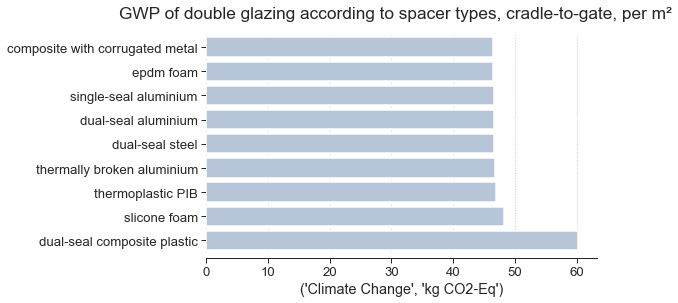

In [55]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impacts_spacers,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_spacers.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to spacer types, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [56]:
df_norm_impacts_spacers = df_impacts_spacers / df_impacts_spacers.max()
df_norm_impacts_spacers.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal           0.77              0.73    0.51   
epdm foam                                 0.77              0.75    0.51   
single-seal aluminium                     0.77              0.86    0.53   
dual-seal aluminium                       0.77              0.87    0.53   
dual-seal steel                           0.77              0.88    0.53   
thermally broken aluminium                0.78              0.87    0.54   
thermoplastic PIB                         0.78              0.77    0.53   
slicone foam                              0.80              0.79    0.56   
dual-seal composite plastic               1.00              1.00    1.00   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.83     0.89         0.82       0.87   
epdm foam                            0.83     0.89         0.85       0.87   
single-seal aluminium                0.84     0.89         0.85       0.87   
dual-seal aluminium                  0.84     0.89         0.85       0.87   
dual-seal steel                      0.84     0.89         0.85       0.87   
thermally broken aluminium           0.84     0.89         0.85       0.87   
thermoplastic PIB                    0.84     0.89         0.92       0.87   
slicone foam                         0.85     0.90         1.00       0.89   
dual-seal composite plastic          1.00     1.00         0.98       1.00   

Method                          Resources         
Unit                            megajoule points  
Name                                              
composite with corrugated metal      0.77   0.69  
epdm foam                            0.76   0.70  
single-seal aluminium                0.76   0.71  
dual-seal aluminium                  0.76   0.71  
dual-seal steel                      0.76   0.71  
thermally broken aluminium           0.77   0.71  
thermoplastic PIB                    0.77   0.71  
slicone foam                         0.80   0.74  
dual-seal composite plastic          1.00   1.00

**Comparative analysis of different infill gases:**

In [57]:
inv_gas = [act for act in bw.Database("exldb_spacers")
           if 'thermally broken aluminium' in act['name']
           ]

fu_gas = [{igu: 1} for igu in inv_gas]
fu_gas

[{'double glazing production, thermally broken aluminium, xenon' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, argon' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, air' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, krypton' (square meter, BE, ('building components/windows',)): 1}]

In [58]:
impacts_gas = []

for igu in inv_gas:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_gas.append((igu["name"], igu["location"],
                            method[1].title(), lca.score,
                            bw.methods.get(method).get('unit')))

# impacts_gas

In [59]:
df_impacts_gas = pd.DataFrame(
    impacts_gas,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_gas = pd.pivot_table(
    df_impacts_gas, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [60]:
df_impacts_gas = df_impacts_gas.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_gas = df_impacts_gas.reset_index()
df_impacts_gas['Name'] = (df_impacts_gas['Name']
                          .str.replace('double glazing production, ', '')
                          )

df_impacts_gas = df_impacts_gas.set_index('Name')

In [61]:
df_impacts_gas.round(2)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air              46.77             16.87    0.01   
thermally broken aluminium, argon            46.84             16.89    0.01   
thermally broken aluminium, krypton          51.45             18.36    0.01   
thermally broken aluminium, xenon            64.19             22.77    0.02   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.38     1.01          0.0   
thermally broken aluminium, argon        0.38     1.01          0.0   
thermally broken aluminium, krypton      0.40     1.05          0.0   
thermally broken aluminium, xenon        0.47     1.15          0.0   

Method                                         Resources          
Unit                                kg NMVOC-. megajoule  points  
Name                                                              
thermally broken aluminium, air           0.24    631.98  222.90  
thermally broken aluminium, argon         0.24    633.91  223.54  
thermally broken aluminium, krypton       0.25    707.03  240.35  
thermally broken aluminium, xenon         0.28   1039.04  330.55

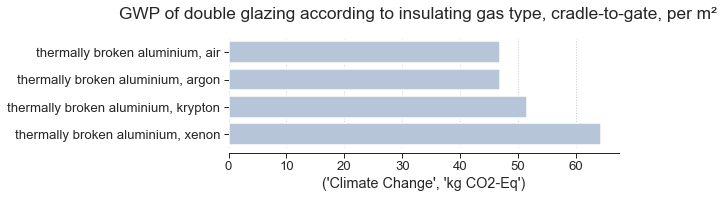

In [62]:
fig, ax = plt.subplots(figsize=(7, 2))

sns.barplot(data=df_impacts_gas,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_gas.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to insulating gas type,' +
    ' cradle-to-gate, per m²', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [63]:
df_norm_impacts_gas = df_impacts_gas / df_impacts_gas.max()
df_norm_impacts_gas.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air               0.73              0.74    0.23   
thermally broken aluminium, argon             0.73              0.74    0.24   
thermally broken aluminium, krypton           0.80              0.81    0.34   
thermally broken aluminium, xenon             1.00              1.00    1.00   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.80     0.88         0.85   
thermally broken aluminium, argon        0.80     0.88         0.85   
thermally broken aluminium, krypton      0.85     0.92         0.87   
thermally broken aluminium, xenon        1.00     1.00         1.00   

Method                                         Resources         
Unit                                kg NMVOC-. megajoule points  
Name                                                             
thermally broken aluminium, air           0.86      0.61   0.67  
thermally broken aluminium, argon         0.86      0.61   0.68  
thermally broken aluminium, krypton       0.90      0.68   0.73  
thermally broken aluminium, xenon         1.00      1.00   1.00

## Comparative LCA of Different Designs for IGU, Cradle-to-Gate

In [64]:
inv_igus = [act for act in bw.Database("exldb_igu")
            if 'market' in act['name']
            and ('glazing' in act['name']
            or 'vacuum' in act['name'])
            ]

fu_igus = [{igu: 1} for igu in inv_igus]

fu_igus

[{'market for triple glazing, lsg, two coatings' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, two coatings, xenon' (square meter, BE, ('building components', 'windows')): 1},
 {'market for smart glass, double glazing' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, two coatings, xenon' (square meter, BE, ('building components', 'windows')): 1},
 {'market for single glazing, lsg' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, vacuum' (square meter, BE, 

In [65]:
impacts_igus = []

for igu in inv_igus:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_igus.append((igu["name"], igu["location"],
                             method[1].title(), lca.score,
                             bw.methods.get(method).get('unit')))

# impacts_igus

In [66]:
df_impacts_igus = pd.DataFrame(
    impacts_igus,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_igus = pd.pivot_table(
    df_impacts_igus, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [67]:
df_impacts_igus = df_impacts_igus.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_igus = df_impacts_igus.reset_index()
df_impacts_igus['Name'] = (df_impacts_igus['Name']
                           .str.replace('market for ', ''))

df_impacts_igus = df_impacts_igus.set_index('Name')

In [68]:
df_impacts_igus.round(2)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                 38.01             14.19   
single glazing, lsg, coated                         38.83             15.24   
double glazing, coated                              48.10             19.50   
double glazing, lsg                                 62.16             24.81   
double glazing, lsg, coated                         63.45             26.46   
double glazing, lsg, two coatings                   64.27             27.51   
double glazing, lsg, vacuum                         65.37             23.64   
triple glazing, coated                              66.00             27.30   
double glazing, lsg, coated, krypton                68.63             28.11   
triple glazing, lsg, two coatings                   81.37             33.19   
triple glazing, lsg, coated                         81.66             35.09   
double glazing, lsg, two coatings, xenon            83.78             34.12   
triple glazing, lsg, two coatings, krypton          91.75             36.48   
triple glazing, lsg, two coatings, xenon           120.40             46.41   
smart glass, double glazing                        701.06           1677.25   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.01      0.26     0.71   
single glazing, lsg, coated                   0.01      0.27     0.72   
double glazing, coated                        0.01      0.38     1.03   
double glazing, lsg                           0.01      0.45     1.21   
double glazing, lsg, coated                   0.01      0.47     1.24   
double glazing, lsg, two coatings             0.01      0.47     1.25   
double glazing, lsg, vacuum                   0.01      0.47     1.25   
triple glazing, coated                        0.01      0.53     1.41   
double glazing, lsg, coated, krypton          0.01      0.49     1.29   
triple glazing, lsg, two coatings             0.01      0.61     1.62   
triple glazing, lsg, coated                   0.01      0.61     1.62   
double glazing, lsg, two coatings, xenon      0.03      0.58     1.41   
triple glazing, lsg, two coatings, krypton    0.02      0.66     1.72   
triple glazing, lsg, two coatings, xenon      0.05      0.82     1.94   
smart glass, double glazing                   0.23      3.29     9.85   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                 0.0       0.17    640.29   
single glazing, lsg, coated                         0.0       0.18    657.20   
double glazing, coated                              0.0       0.25    651.46   
double glazing, lsg                                 0.0       0.29    974.92   
double glazing, lsg, coated                         0.0       0.30   1001.44   
double glazing, lsg, two coatings                   0.0       0.30   1018.35   
double glazing, lsg, vacuum                         0.0       0.30   1028.08   
triple glazing, coated                              0.0       0.34    895.11   
double glazing, lsg, coated, krypton                0.0       0.31   1083.53   
triple glazing, lsg, two coatings                   0.0       0.39   1249.86   
triple glazing, lsg, coated                         0.0       0.39   1249.81   
double glazing, lsg, two coatings, xenon            0.0       0.35   1473.95   
triple glazing, lsg, two coatings, krypton          0.0       

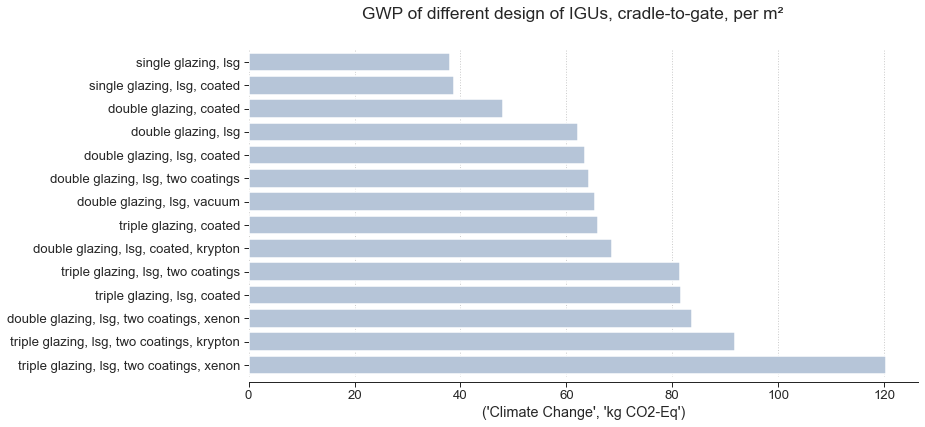

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

df_impacts_igus_wo_smartg = df_impacts_igus.drop(
    "smart glass, double glazing", axis=0
)

sns.barplot(data=df_impacts_igus_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus_wo_smartg.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [70]:
df_norm_impacts_igus_wo_smartg = (
    df_impacts_igus_wo_smartg / df_impacts_igus_wo_smartg.max()
)

df_norm_impacts_igus_wo_smartg.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.32              0.31   
single glazing, lsg, coated                          0.32              0.33   
double glazing, coated                               0.40              0.42   
double glazing, lsg                                  0.52              0.53   
double glazing, lsg, coated                          0.53              0.57   
double glazing, lsg, two coatings                    0.53              0.59   
double glazing, lsg, vacuum                          0.54              0.51   
triple glazing, coated                               0.55              0.59   
double glazing, lsg, coated, krypton                 0.57              0.61   
triple glazing, lsg, two coatings                    0.68              0.72   
triple glazing, lsg, coated                          0.68              0.76   
double glazing, lsg, two coatings, xenon             0.70              0.74   
triple glazing, lsg, two coatings, krypton           0.76              0.79   
triple glazing, lsg, two coatings, xenon             1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.11      0.32     0.36   
single glazing, lsg, coated                   0.11      0.33     0.37   
double glazing, coated                        0.11      0.47     0.53   
double glazing, lsg                           0.16      0.56     0.63   
double glazing, lsg, coated                   0.17      0.57     0.64   
double glazing, lsg, two coatings             0.18      0.58     0.65   
double glazing, lsg, vacuum                   0.16      0.57     0.65   
triple glazing, coated                        0.15      0.64     0.73   
double glazing, lsg, coated, krypton          0.22      0.60     0.66   
triple glazing, lsg, two coatings             0.22      0.75     0.84   
triple glazing, lsg, coated                   0.21      0.74     0.84   
double glazing, lsg, two coatings, xenon      0.57      0.70     0.73   
triple glazing, lsg, two coatings, krypton    0.32      0.81     0.89   
triple glazing, lsg, two coatings, xenon      1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.48       0.36      0.30   
single glazing, lsg, coated                        0.48       0.37      0.30   
double glazing, coated                             0.42       0.52      0.30   
double glazing, lsg                                0.69       0.62      0.45   
double glazing, lsg, coated                        0.70       0.63      0.46   
double glazing, lsg, two coatings                  0.70       0.64      0.47   
double glazing, lsg, vacuum                        0.71       0.64      0.48   
triple glazing, coated                             0.57       0.71      0.41   
double glazing, lsg, coated, krypton               0.71       0.66      0.50   
triple glazing, lsg, two coatings                  0.84       0.82      0.58   
triple glazing, lsg, coated                        0.85       0.82      0.58   
double glazing, lsg, two coatings, xenon           0.78       0.73      0.68   
triple glazing, lsg, two coatings, krypton         0.87       0.87      0.65   
triple glazing, lsg, two coatings, xenon           1.00       1.00      1.00   

Method                                             
U

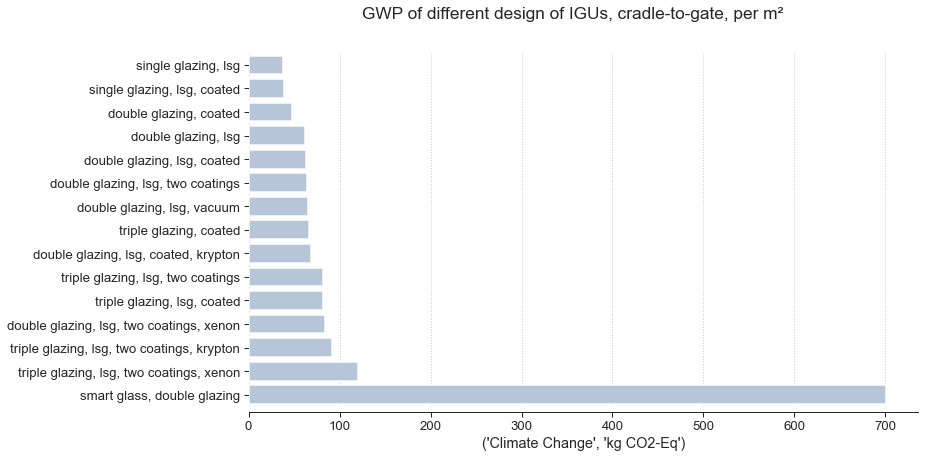

In [71]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(data=df_impacts_igus,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [72]:
df_norm_impacts_igus = df_impacts_igus / df_impacts_igus.max()
df_norm_impacts_igus.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.05              0.01   
single glazing, lsg, coated                          0.06              0.01   
double glazing, coated                               0.07              0.01   
double glazing, lsg                                  0.09              0.01   
double glazing, lsg, coated                          0.09              0.02   
double glazing, lsg, two coatings                    0.09              0.02   
double glazing, lsg, vacuum                          0.09              0.01   
triple glazing, coated                               0.09              0.02   
double glazing, lsg, coated, krypton                 0.10              0.02   
triple glazing, lsg, two coatings                    0.12              0.02   
triple glazing, lsg, coated                          0.12              0.02   
double glazing, lsg, two coatings, xenon             0.12              0.02   
triple glazing, lsg, two coatings, krypton           0.13              0.02   
triple glazing, lsg, two coatings, xenon             0.17              0.03   
smart glass, double glazing                          1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.02      0.08     0.07   
single glazing, lsg, coated                   0.02      0.08     0.07   
double glazing, coated                        0.02      0.12     0.10   
double glazing, lsg                           0.03      0.14     0.12   
double glazing, lsg, coated                   0.04      0.14     0.13   
double glazing, lsg, two coatings             0.04      0.14     0.13   
double glazing, lsg, vacuum                   0.04      0.14     0.13   
triple glazing, coated                        0.03      0.16     0.14   
double glazing, lsg, coated, krypton          0.05      0.15     0.13   
triple glazing, lsg, two coatings             0.05      0.19     0.16   
triple glazing, lsg, coated                   0.05      0.19     0.16   
double glazing, lsg, two coatings, xenon      0.12      0.17     0.14   
triple glazing, lsg, two coatings, krypton    0.07      0.20     0.17   
triple glazing, lsg, two coatings, xenon      0.21      0.25     0.20   
smart glass, double glazing                   1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.04       0.06      0.06   
single glazing, lsg, coated                        0.04       0.06      0.06   
double glazing, coated                             0.04       0.09      0.06   
double glazing, lsg                                0.06       0.10      0.09   
double glazing, lsg, coated                        0.06       0.11      0.09   
double glazing, lsg, two coatings                  0.06       0.11      0.09   
double glazing, lsg, vacuum                        0.06       0.11      0.09   
triple glazing, coated                             0.05       0.12      0.08   
double glazing, lsg, coated, krypton               0.06       0.11      0.10   
triple glazing, lsg, two coatings                  0.07       0.14      0.12   
triple glazing, lsg, coated                        0.07       0.14      0.12   
double glazing, lsg, two coatings, xenon           0.07       0.12      0.14   
triple glazing, lsg, two coatings, krypton         0.08       

# LCA of Curtain Wall Systems, from Cradle to Gate

## Environmental Impact

**Comparative analysis of different CW configurations:**

In [73]:
inv_cw = [act for act in bw.Database("exldb_cw")
          if 'market for curtain wall' in act['name']
          # and 'xenon' not in act['name']
          # and 'air' not in act['name']
          ]

fu_cw = [{cw: 1} for cw in inv_cw]

In [74]:
impacts_cw = []

for cw in inv_cw:
    lca = bw.LCA({cw: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_cw.append((cw["name"], cw["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

In [75]:
df_impacts_cw = pd.DataFrame(
    impacts_cw,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_cw = pd.pivot_table(
    df_impacts_cw, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [76]:
df_impacts_cw = df_impacts_cw.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_cw = df_impacts_cw.reset_index()
df_impacts_cw['Name'] = (df_impacts_cw['Name']
                         .str.replace('double glazing production, ', '')
                         .str.replace(', argon', ''))

df_impacts_cw = df_impacts_cw.set_index('Name')

In [77]:
df_impacts_cw.round(2)

Method                                             Climate Change  \
Unit                                                    kg CO2-Eq   
Name                                                                
market for curtain wall, single glazing, low pe...         132.06   
market for curtain wall, single glazing, coated...         132.83   
market for curtain wall, double glazing, low pe...         158.63   
market for curtain wall, double glazing, coated...         162.82   
market for curtain wall, double glazing, two co...         163.60   
market for curtain wall, vacuum double glazing,...         164.64   
market for curtain wall, double glazing, coated...         167.73   
market for curtain wall, triple glazing, two co...         188.17   
market for curtain wall, triple glazing, coated...         188.44   
market for curtain wall, triple glazing, two co...         197.98   
market for curtain wall, triple glazing, two co...         225.10   
market for curtain wall, double skin facade                289.08   
market for curtain wall, ccf                               434.54   
market for curtain wall, smart glazing, high pe...         774.14   

Method                                             Ecosystem Quality          \
Unit                                                             CTU kg P-Eq   
Name                                                                           
market for curtain wall, single glazing, low pe...            198.35    0.05   
market for curtain wall, single glazing, coated...            199.35    0.05   
market for curtain wall, double glazing, low pe...            213.90    0.05   
market for curtain wall, double glazing, coated...            218.14    0.05   
market for curtain wall, double glazing, two co...            219.13    0.05   
market for curtain wall, vacuum double glazing,...            215.46    0.05   
market for curtain wall, double glazing, coated...            219.70    0.06   
market for curtain wall, triple glazing, two co...            240.14    0.06   
market for curtain wall, triple glazing, coated...            241.94    0.06   
market for curtain wall, triple glazing, two co...            243.26    0.06   
market for curtain wall, triple glazing, two co...            252.65    0.10   
market for curtain wall, double skin facade                   426.04    0.10   
market for curtain wall, ccf                                  582.27    0.17   
market for curtain wall, smart glazing, high pe...           1791.16    0.26   

Method                                                                 \
Unit                                               mol H+-Eq mol N-Eq   
Name                                                                    
market for curtain wall, single glazing, low pe...      0.91     1.76   
market for curtain wall, single glazing, coated...      0.92     1.78   
market for curtain wall, double glazing, low pe...      1.12     2.28   
market for curtain wall, double glazing, coated...      1.15     2.33   
market for curtain wall, double glazing, two co...      1.15     2.34   
market for curtain wall, vacuum double glazing,...      1.15     2.34   
market for curtain wall, double glazing, coated...      1.17     2.37   
market for curtain wall, triple glazing, two co...      1.34     2.78   
market for curtain wall, triple glazing, coated...      1.34     2.77   
market for curtain wall, triple glazing, two co...      1.39     2.87   
market for curtain wall, triple glazing, two co...      1.54     3.07   
market for curtain wall, double skin facade             2.04     4.05   
market for curtain wall, ccf                            3.06     5.35   
market for curtain wall, smart glazing, high pe...      3.88    10.55   

Method                                             Human Health             \
Unit                                                 kg CFC-11. kg NMVOC-.   
Name                                                               

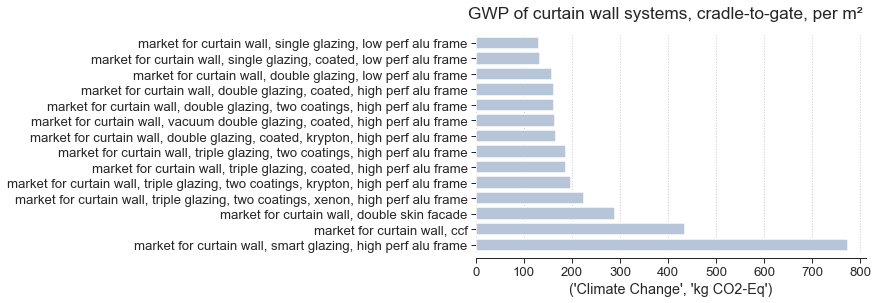

In [78]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impacts_cw,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_cw.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of curtain wall systems, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

## Uncertainty Analysis through Monte Carlo Simulation

Define the number of iterations:

In [ ]:
n_runs = 100

### For a Single Activity, MC for GWP

In [236]:
fu_cw

[{'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, two coatings, xenon, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, two coatings, krypton, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, double glazing, coated, krypton, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, double glazing, two coatings, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, single glazing, coated, low perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall,

In [237]:
act = "market for curtain wall, double glazing, coated, high perf alu frame"

for fu in fu_cw:
    for key, value in fu.items():
        if act in str(key):
            print(key)
            mc_fu = fu

'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows'))


In [238]:
# Simple montecarlo:
mc = MonteCarloLCA(mc_fu, method_ilcd_gwp)
ls_mc_results = [next(mc_fu) for n in range(n_runs)]

In [239]:
pd.DataFrame(ls_mc_results).describe()

,0
count,100.000000
mean,179.217418
std,11.273785
min,156.762601
25%,172.162488
50%,178.521497
75%,184.335900
max,229.028478


{'market for curtain wall, triple glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1}


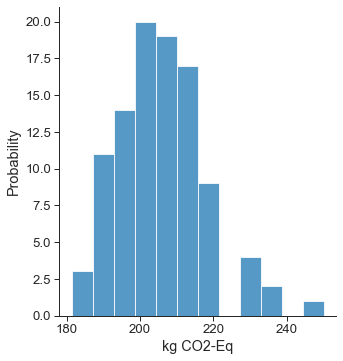

In [82]:
sns.displot(data=ls_mc_results)

plt.ylabel("Probability")
plt.xlabel(methods[method_ilcd_gwp]["unit"])

print(mc_fu)

### Comparative MonteCarlo Analysis of Different IGUs

Conduct the uncertainty analysis? If not, recover csv file (if exists):

In [116]:
mc_bool = False

In [133]:
if mc_bool:
    # Now, a comparative analysis of different IGUs:
    simulations = []
    ls_col = []

    for n in range(n_runs):
        next(mc)
        ls_mcresults = []    
        for fu in fu_cw:
            mc.redo_lcia(fu)
            ls_mcresults.append(mc.score)

        simulations.append(ls_mcresults)

    for fu in fu_cw:
        a = [label for label, q in fu.items()]
        ls_col.append(a[0]["name"])

    df_mc_results = pd.DataFrame(simulations, columns = ls_col)
    
    df_mc_results.to_csv('outputs\lca\mc_results_igus.csv')
    
else:
    if os.path.isfile('outputs\lca\mc_results_igus.csv'):
        df_mc_results_csv = (
            pd.read_csv('outputs\lca\mc_results_igus.csv'))
        
        df_mc_results_csv = df_mc_results_csv.rename(
            columns={"Unnamed: 0":"Iteration"}
        ).set_index("Iteration")

        df_mc_results = df_mc_results_csv
    
    else:
        print("MonteCarlo DataFrame is empty!")   

In [214]:
df_mc_results.describe()

,"market for curtain wall, double glazing, coated, high perf alu frame","market for curtain wall, triple glazing, coated, high perf alu frame","market for curtain wall, triple glazing, two coatings, xenon, high perf alu frame","market for curtain wall, triple glazing, two coatings, krypton, high perf alu frame","market for curtain wall, double glazing, coated, krypton, high perf alu frame","market for curtain wall, double glazing, two coatings, high perf alu frame","market for curtain wall, single glazing, coated, low perf alu frame","market for curtain wall, vacuum double glazing, coated, high perf alu frame","market for curtain wall, double glazing, low perf alu frame","market for curtain wall, single glazing, low perf alu frame","market for curtain wall, smart glazing, high perf alu frame","market for curtain wall, triple glazing, two coatings, high perf alu frame","market for curtain wall, double skin facade","market for curtain wall, ccf"
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,179.880046,207.242068,247.655681,217.851317,185.305790,180.799412,147.598042,181.643286,174.883339,146.674886,897.495966,206.999829,320.107184,472.061480
std,12.343141,12.907416,14.862219,13.112465,12.389288,12.399591,11.864690,12.418906,12.264762,11.818267,133.310342,12.973035,23.986843,24.518373
min,159.517447,185.095159,216.702253,193.783181,164.146911,160.310016,129.217374,161.083500,155.178627,128.245804,655.943128,184.524253,282.422166,410.664037
25%,173.140015,200.108679,237.977799,210.183402,178.041603,174.076426,140.659842,174.887685,167.891316,139.905523,795.252932,199.972381,306.446213,457.273422
50%,177.341611,204.679077,245.551687,215.814805,183.095386,178.201120,145.094301,178.942688,172.700929,144.092575,895.145848,204.275980,315.357013,470.020168
75%,185.657796,213.694666,255.225576,224.150347,190.875698,186.641299,151.612837,187.402909,179.771536,150.570408,962.860391,213.653908,329.681351,486.071152
max,247.007311,276.148562,314.215244,286.378255,252.108245,248.179143,212.503342,249.166541,241.812722,211.326679,1321.884196,276.176389,448.440817,555.721175


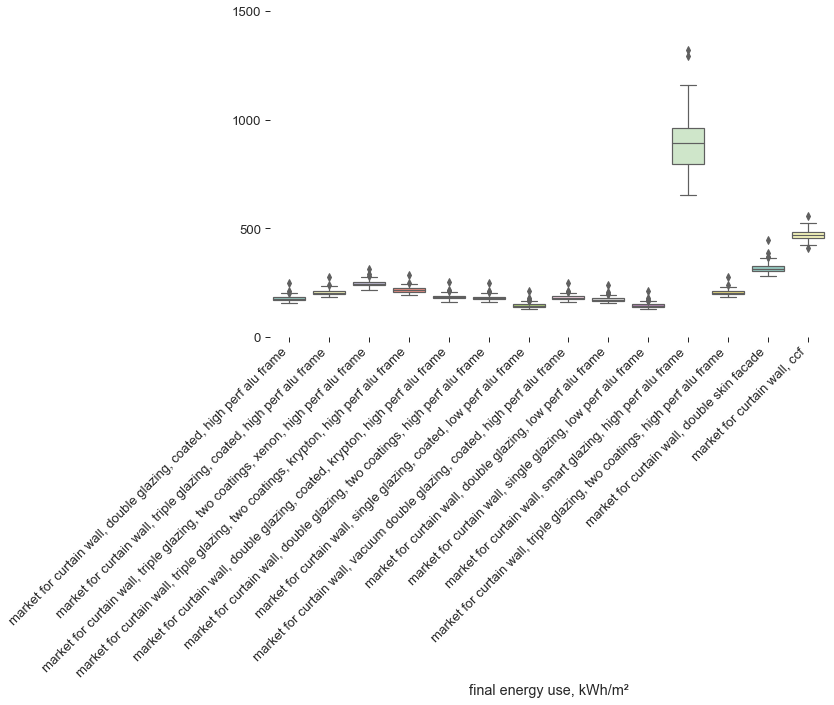

In [134]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.boxplot(data=df_mc_results, palette="Set3")

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 1501, 500))
sns.despine(left=True, bottom=True, offset=5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

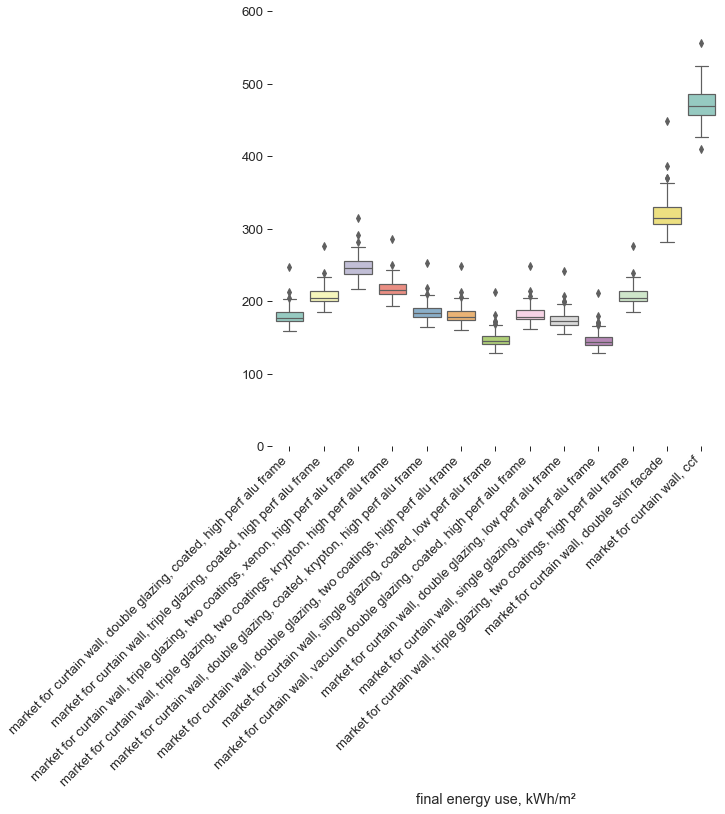

In [135]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.boxplot(
    data=df_mc_results[
        [x for x in df_mc_results.columns if 'smart glazing' not in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 601, 100))
sns.despine(left=True, bottom=True, offset=5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

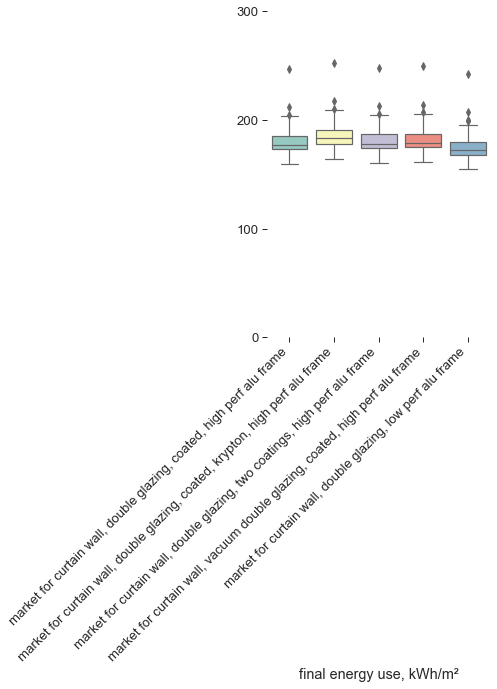

In [136]:
fig, ax = plt.subplots(figsize=(4, 6))

ax = sns.boxplot(
    data=df_mc_results[
        [x for x in df_mc_results.columns if 'double glazing' in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 301, 100))
sns.despine(left=True, bottom=True, offset=5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

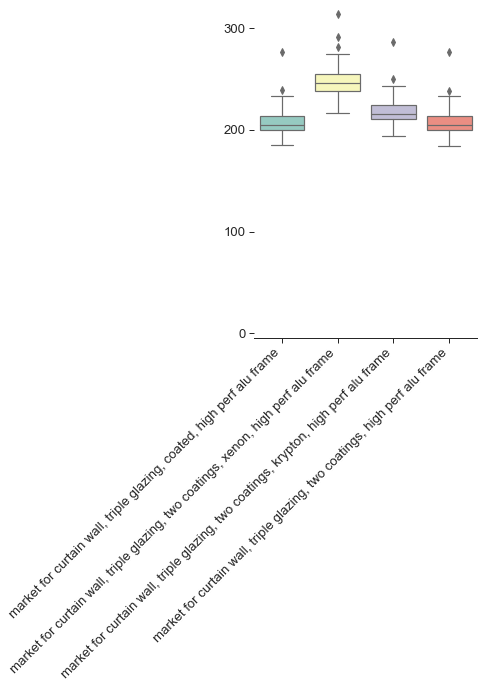

In [208]:
fig, ax = plt.subplots(figsize=(4, 6))

ax = sns.boxplot(
    data=df_mc_results[
        [x for x in df_mc_results.columns if 'triple glazing' in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 301, 100))
sns.despine(left=True, offset=5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

### Monte Carlo Analysis for Multiple Impact Categories

In [151]:
# define the function for MC simulation
def multiImpactMonteCarloLCA(fu, ls_methods, nruns):
    
    mc_lca = bw.MonteCarloLCA(fu)
    mc_lca.lci()
    
    c_matrices = {}
    
    for method in ls_methods:
        mc_lca.switch_method(method)
        c_matrices[method] = mc_lca.characterization_matrix
    
    results = np.empty((len(ls_methods), nruns))
    
    for iteration in range(nruns):
        next(mc_lca)
        for method_index, method in enumerate(ls_methods):
            results[method_index, iteration] = (
                c_matrices[method]*mc_lca.inventory).sum()
            
    return results

In [216]:
fu_cw

[{'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, two coatings, xenon, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, triple glazing, two coatings, krypton, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, double glazing, coated, krypton, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, double glazing, two coatings, high perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall, single glazing, coated, low perf alu frame' (square meter, BE, ('building components', 'windows')): 1},
 {'market for curtain wall,

In [235]:
act = "market for curtain wall, double glazing, coated, high perf alu frame"

for fu in fu_cw:
    for key, value in fu.items():
        if act in str(key):
            print(key)
            mc_fu = fu

'market for curtain wall, double glazing, coated, high perf alu frame' (square meter, BE, ('building components', 'windows'))


In [241]:
if mc_bool:
    
    mc_results = multiImpactMonteCarloLCA(mc_fu,
                                          methods_full, 
                                          n_runs
                                         )
    
    df_multiimpact_mc_results = pd.DataFrame(data=mc_results, 
                                             index=methods_full).T
    
    df_multiimpact_mc_results.to_csv('outputs\lca\multiimpact_mc_results.csv',
                                    index_label="Iteration")
    
else:
    if os.path.isfile('outputs\lca\multiimpact_mc_results.csv'):
        df_multiimpact_mc_results_csv = (
            pd.read_csv('outputs\lca\multiimpact_mc_results.csv'))
        df_multiimpact_mc_results_csv = (
            df_multiimpact_mc_results_csv.set_index("Iteration")
        )

        df_multiimpact_mc_results = df_multiimpact_mc_results_csv
    
    else:
        print("MonteCarlo DataFrame is empty!")   

In [242]:
df_multiimpact_mc_results.head()

,"(ILCD 2.0 2018 midpoint, climate change, climate change total)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater ecotoxicity)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater and terrestrial acidification)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, marine eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, terrestrial eutrophication)","(ILCD 2.0 2018 midpoint, human health, non-carcinogenic effects)","(ILCD 2.0 2018 midpoint, human health, carcinogenic effects)","(ILCD 2.0 2018 midpoint, human health, ionising radiation)","(ILCD 2.0 2018 midpoint, human health, ozone layer depletion)","(ILCD 2.0 2018 midpoint, human health, photochemical ozone creation)","(ILCD 2.0 2018 midpoint, human health, respiratory effects, inorganics)","(ILCD 2.0 2018 midpoint, resources, minerals and metals)","(ILCD 2.0 2018 midpoint, resources, dissipated water)","(ILCD 2.0 2018 midpoint, resources, fossils)","(ILCD 2.0 2018 midpoint, resources, land use)"
0,178.993558,628.674050,1.436094,0.045990,0.259641,3.010618,0.000065,0.000054,17.175325,0.000021,0.822833,0.000013,0.010384,108.478947,2719.851867,2135.548316
1,192.869031,383.698896,1.268697,0.075424,0.246506,2.705244,-0.000331,0.000017,132.356290,0.000029,0.788387,0.000013,0.010140,133.667891,3268.936195,2065.675815
2,173.741877,328.772790,1.247518,0.149651,0.239163,2.670822,-0.000095,0.000020,45.359807,0.000024,0.735480,0.000013,0.011420,115.803122,2441.323130,2272.479565
3,186.077942,279.929818,1.396958,0.074326,0.234662,3.007630,-0.000042,0.000018,24.212155,0.000015,0.729363,0.000014,0.016846,121.292189,3212.241016,3587.965259
4,174.490929,209.084580,1.245927,0.058893,0.229277,2.598248,0.000254,0.000013,26.700552,0.000026,0.739562,0.000011,0.008185,112.572476,2872.983689,1935.380852


In [243]:
df_multiimpact_mc_results.describe()

,"(ILCD 2.0 2018 midpoint, climate change, climate change total)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater ecotoxicity)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater and terrestrial acidification)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, marine eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, terrestrial eutrophication)","(ILCD 2.0 2018 midpoint, human health, non-carcinogenic effects)","(ILCD 2.0 2018 midpoint, human health, carcinogenic effects)","(ILCD 2.0 2018 midpoint, human health, ionising radiation)","(ILCD 2.0 2018 midpoint, human health, ozone layer depletion)","(ILCD 2.0 2018 midpoint, human health, photochemical ozone creation)","(ILCD 2.0 2018 midpoint, human health, respiratory effects, inorganics)","(ILCD 2.0 2018 midpoint, resources, minerals and metals)","(ILCD 2.0 2018 midpoint, resources, dissipated water)","(ILCD 2.0 2018 midpoint, resources, fossils)","(ILCD 2.0 2018 midpoint, resources, land use)"
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,178.808690,337.178896,1.303208,0.083677,0.237464,2.732872,0.000014,0.000022,59.273519,0.000023,0.747114,0.000014,0.012954,120.147912,2864.258404,2237.470419
std,8.978339,143.508068,0.105802,0.033345,0.017860,0.346895,0.000296,0.000012,68.439613,0.000007,0.059229,0.000002,0.006666,9.509581,272.991733,621.363322
min,163.675474,162.525329,1.099792,0.023674,0.203244,2.213506,-0.000718,0.000006,9.140262,0.000014,0.642001,0.000010,0.005127,96.694532,2441.323130,1446.998479
25%,171.815695,239.166270,1.225039,0.059630,0.226221,2.497642,-0.000127,0.000013,20.786450,0.000019,0.708706,0.000012,0.009055,113.206737,2666.373221,1859.839412
50%,177.956166,301.059824,1.291252,0.075932,0.236937,2.675503,-0.000005,0.000019,31.450887,0.000021,0.741900,0.000013,0.010760,119.554113,2828.535396,2058.780826
75%,185.182004,385.070676,1.361762,0.104028,0.246323,2.855279,0.000134,0.000027,71.012331,0.000024,0.777530,0.000015,0.015399,126.826977,3021.290983,2378.519517
max,204.029205,1025.275934,1.615344,0.176017,0.306401,4.026812,0.001416,0.000069,470.497304,0.000072,0.975998,0.000022,0.042428,142.558703,3801.719371,4609.033168


In [244]:
df_multiimpact_mc_results.columns

Index([                       ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
                         ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
       ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater and terrestrial acidification'),
                      ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
                          ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
                     ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
                            ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
                                ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
                                  ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
                               ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),


In [245]:
impact = 'freshwater ecotoxicity'

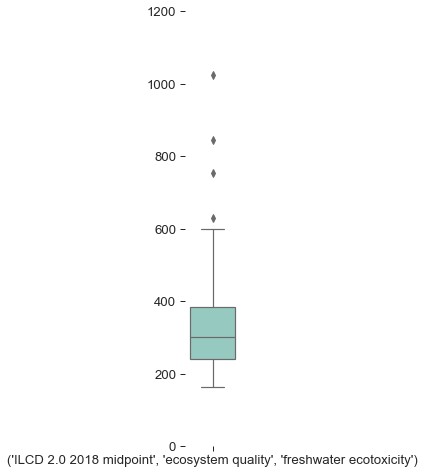

In [246]:
fig, ax = plt.subplots(figsize=(1, 8))

ax = sns.boxplot(
    data=df_multiimpact_mc_results[
        [x for x in df_multiimpact_mc_results.columns if impact in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 1201, 200))
sns.despine(left=True, bottom=True)

# Import Results from the BEM

## Recover Data Saved in CSV Files from Previous Simulations:

To read directly the csv file and work from them instead of relaunching the energy simulation (Please note that this does not prevent the simulations from being run again. To do this, change the run_all boolean variable above. If the simulations are rerun, the new results will overwrite the old ones saved in the csv files):

Dataframe with all energy usage data per simulation run:

Retrieve the data from the csv. The simulation_postprocess function will merge the new results by overwriting the old ones, or simply add the new ones if they did not exist yet.

In [247]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

A function to recover df_step dataframes saved as csv, i.e. DataFrame with the main assumptions and results (natural gas and electricity) specific to each simulation run:

To assess the indirect impact of glazing replacement on energy use in the building, the natural gas and electricity use results for each scenario are subtracted by the initial scenario, where the exact same glazing is kept. 

In [248]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe wich replace 
    the one currently in use in the notebook.
    Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv"):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step ", n_step, "updated with csv data")
    else:
        print("existing df_step ", n_step, "kept in place")

    return df_step

## Recover and Post-Process the df_step Dataframes:

As a reminder: df_step units are MJ/m² of glazed façade for natural gas, and kWh/m² for electricity use.

In [249]:
df_step1 = recover_df_step(1, df_step1)
df_step1.name = "df_step1"
df_step2 = recover_df_step(2, df_step2)
df_step2.name = "df_step2"
df_step3 = recover_df_step(3, df_step3)
df_step3.name = "df_step3"
df_step4 = recover_df_step(4, df_step4)
df_step4.name = "df_step4"
df_step5 = recover_df_step(5, df_step5)
df_step5.name = "df_step5"
df_step6 = recover_df_step(6, df_step6)
df_step6.name = "df_step6"
df_step7 = recover_df_step(7, df_step7)
df_step7.name = "df_step7"
df_step8 = recover_df_step(8, df_step8)
df_step8.name = "df_step8"
df_step9 = recover_df_step(9, df_step9)
df_step9.name = "df_step9"
df_step10 = recover_df_step(10, df_step10)
df_step10.name = "df_step10"
df_step11 = recover_df_step(11, df_step11)
df_step11.name = "df_step11"
df_step12 = recover_df_step(12, df_step12)
df_step12.name = "df_step12"
df_step13 = recover_df_step(13, df_step13)
df_step13.name = "df_step13"
df_step14 = recover_df_step(14, df_step14)
df_step14.name = "df_step14"
df_step15 = recover_df_step(15, df_step15)
df_step15.name = "df_step15"
df_step16 = recover_df_step(16, df_step16)
df_step16.name = "df_step16"

df_step  1 updated with csv data
df_step  2 updated with csv data
df_step  3 updated with csv data
df_step  4 updated with csv data
df_step  5 updated with csv data
df_step  6 updated with csv data
df_step  7 updated with csv data
df_step  8 updated with csv data
df_step  9 updated with csv data
df_step  10 updated with csv data
df_step  11 updated with csv data
df_step  12 updated with csv data
df_step  13 updated with csv data
df_step  14 updated with csv data
df_step  15 updated with csv data
df_step  16 updated with csv data


In [250]:
# Initial HVAC configuration, "inefficient" fan coils (steps 1, 2, 3):
# Subtraction of energy use by that in the initial scenario:
if not df_step1.loc[df_step1["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step1, df_step2, df_step3]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 1! energy use not substracted by dg_init!")

In [251]:
# Optimised HVAC system, VAV, (steps 4, 5, 8, 9):
# Subtraction of energy use by that in the initial scenario:
if not df_step4.loc[df_step4["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step4, df_step5, df_step8, df_step9,
                    df_step10, df_step11, df_step12, df_step13]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 4! energy use not substracted by dg_init!")

In [252]:
# Fully electrified HVAC system, VRF, (steps 6, 7):
# Subtraction of energy use by that in the initial scenario:
if not df_step6.loc[df_step6["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step6, df_step7]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 6! energy use not substracted by dg_init!")

In [253]:
# Varying weather data, steps: 14, 15, 16:
# Subtraction of energy use by that in the initial scenario:
for df_step in [df_step14, df_step15, df_step16]:
    if not df_step.loc[df_step["glazing"] == "dg_init_bronze"].empty:
        i_gas = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "natural_gas"])
        i_elec = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "elec_use"])

        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

    else:
        print("DG_init not in step ", df_step.name,
              "! energy use not substracted by dg_init!")

# Impact Assessment of the Whole Life Cycle of Curtain Walls Retrofitting

## Setup of the LCA

First, we define the activity of dismantling, and thus disposal, of the existing curtain wall:

In [254]:
out_old_cw = exldb_cw.get('dismantling_cw_old_dg')
# Check:
print('My activity is:\n', out_old_cw)

My activity is:
 'curtain wall, dismantling, old double glazing' (square meter, BE, ('building components', 'windows'))


Then we define the production activity of the new curtain wall:

In [255]:
prod_cw = exldb_cw.get('production_cw')
# Check:
print('My activity is:\n', prod_cw)

My activity is:
 'curtain wall, production' (square meter, BE, ('building components', 'windows'))


We define the use phase activity (not linked to production):

In [256]:
use_bldg_w_cw = exldb_cw.get('use_glazed_office_bldg')
# Check:
print('My activity is:\n', use_bldg_w_cw)

My activity is:
 'use of glazed office building, hvac and lighting' (square meter, BE, ('building components', 'windows'))


We define a use phase activity integrating the production phase:

In [257]:
prod_and_use_cw = exldb_cw.get('use_cw')
# Check:
print('My activity is:\n', prod_and_use_cw)

My activity is:
 'use of curtain wall' (square meter, BE, ('building components', 'windows'))


We define a maintenance activity:

In [258]:
repair_cw = exldb_cw.get('maintenance_cw')
# Check:
print('My activity is:\n', repair_cw)

My activity is:
 'curtain wall, maintenance' (square meter, BE, ('building components', 'windows'))


And finally, the end-of-life activity:

In [259]:
eol_cw = exldb_cw.get('eol_cw')
# Check:
print('My activity is:\n', eol_cw)

My activity is:
 'curtain wall, end of life' (square meter, BE, ('building components', 'windows'))


Define the lifespan (years):

In [260]:
lifespan = [p.amount for p in DatabaseParameter.select()
            if p.name == 'param_lifespan'][0]

## Functions to Perform the LCAs

Write a function to perform the LCA according to activities and parameter sets:

In [261]:
def lca_cw_gwp(df_step, act, fu):
    """
    Perform a simple lca for different scenarios 
    according to parameters defined in df_step

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_results: list of values for IPCC GWP
    """

    # To save results:
    ls_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing',
                             'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu}, method_ilcd_gwp)
        lca.lci()
        lca.lcia()
        ls_results.append({'run': name_scenario, 'result': lca.score})

    return ls_results

Write a function to perform a multi_method LCA, with small_methods, according to activities and parameter sets:

In [262]:
# Reminder of the reduced list of methods:
methods_small

[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
 ('ILCD 2.0 2018 midpoint',
  'ecosystem quality',
  'freshwater and terrestrial acidification'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'land use')]

In [263]:
def lca_cw_mlca_small(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_small_results: list of values
    """

    # To save results:
    ls_mlca_small_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_small:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_small_results.append((name_scenario,
                                          method[2].title(), lca.score,
                                          bw.methods.get(method).get('unit')))

    return ls_mlca_small_results

Write a function to perform a multi_method LCA, with full_methods, according to activities and parameter sets:

In [264]:
# Reminder of the full list of methods:
methods_full

[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
 ('ILCD 2.0 2018 midpoint',
  'ecosystem quality',
  'freshwater and terrestrial acidification'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
 ('ILCD 2.0 2018 mid

In [265]:
def lca_cw_mlca_full(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_full_results: list of values
    """

    # To save results:
    ls_mlca_full_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_full:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_full_results.append((name_scenario,
                                         method[2].title(), lca.score,
                                         bw.methods.get(method).get('unit')))

    return ls_mlca_full_results

A little function to transform a list of mlca_results in a DataFrame:

In [266]:
def ls_to_df_mlca(ls):
    """
    A little function to transform the ls_mlca_results 
    in a readable DataFrame

    Parameters
    ----------
    ls: the list

    Returns
    -------
    df: the DataFrame
    """

    # DataFrame to then work w/ results:
    df = pd.DataFrame(ls,
                      columns=["Name",
                               "Impact Category",
                               "Score",
                               "Unit"
                               ]
                      )

    df = pd.pivot_table(df,
                        index=["Name"],
                        columns=["Impact Category",
                                 "Unit"
                                 ],
                        values="Score"
                        )

    return df

A function to save mlca_full_results in a DataFrame, for each simulation run and LCA phase:

In [267]:
def ls_to_df_mlca_full(step, ls, act, df_results):
    """
    A function to append a list of mlca results in a DataFrame, 
        with values organised per simulation run (index), 
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    ls: the list of results.
    df_results: a DataFrame where LCA results will be saved.
    act: activity for which the LCA has been done.

    Returns
    -------
    df_results
    """

    # New DataFrame from list of results:
    df_temp = pd.DataFrame(ls,
                           columns=["Name",
                                    "Impact Category",
                                    "Score",
                                    "Unit"
                                    ]
                           )

    # Add information regarding the step:
    df_temp["Step"] = step
    # Add information regarding the LCA phase:
    df_temp["LCA Phase"] = str(act["name"])

    # Pivot the DataFrame:
    df_temp = pd.pivot_table(df_temp,
                             index=["Step",
                                    "Name"
                                    ],
                             columns=["LCA Phase",
                                      "Impact Category",
                                      "Unit"
                                      ],
                             values="Score"
                             )
    # Merge with existing results:
    if df_results.empty:
        df_results = df_temp
        print("empty, df_results replaced")
    else:
        # Merge by columns_to_use:
        df_results = pd.concat(
            [df_results, df_temp[~df_temp.index.isin(df_results.index)]]
        )
        df_results.update(df_temp)

    return df_results

A function to conduct a mLCA per activity and save the mlca_full_results in a DataFrame, for each simulation run and each LCA phase:

In [268]:
def full_lca_to_df(step, df_step, df_results, fu):
    """
    A function to conduct and LCA (w/ function: lca_cw_mlca_full)
        and append a list of mlca results in a DataFrame 
        (w/ function: ls_to_df_mlca_full), 
        with values organised per simulation run (index),
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    df_step: DataFrame with list of parameters and their values

    Returns
    -------
    df_results: a DataFrame where LCA results are saved,
        simulation run as index, LCA phase and impact indicators as columns.
    """

    for act in [prod_cw, use_bldg_w_cw, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step, act, fu)
        df_results = ls_to_df_mlca_full(step, ls, act, df_results)

    return df_results

## Environmental Analysis, Step-by-Step

### Life Cycle Impact Assessment

Full life cycle assessment, ILCD methods, from cradle-to-grave, for each simulation run:

<font color="red">Performing the impact assessment or loading the csv file where previous results are stored?<font>

In [269]:
# Do we perform the LCIA?
calc_lcia = False

Be patient, takes time to calculate !

In [270]:
# Initialise a DataFrame:
df_mlca_full_raw_results = pd.DataFrame()

In [271]:
if calc_lcia:
    # LCIA calculation:
    ls_df_step = [
        df_step1, df_step2, df_step3, df_step4, 
        df_step5, df_step6, df_step7, df_step8, 
        df_step9, df_step10, df_step11, df_step12, 
        df_step13, df_step14, df_step15, df_step16
    ]

    n = 1
    for df in ls_df_step:
        step = "step_"+str(n)
        df_mlca_full_raw_results = full_lca_to_df(step, df,
                                                  df_mlca_full_raw_results, 1
                                                  )
        n += 1

    # Save df_mlca_full_raw_results to csv:
    df_mlca_full_raw_results.unstack([0, 1]).to_csv(
        'outputs\steps_dir\df_mlca_full_raw_results.csv', index=True)

else:
    # Open the csv file, to avoid recalculating the impacts:
    if os.path.isfile('outputs\steps_dir\df_mlca_full_raw_results.csv'):
        df_mlca_full_raw_results = (
            pd.read_csv('outputs\steps_dir\df_mlca_full_raw_results.csv')
        )
        df_mlca_full_raw_results = df_mlca_full_raw_results.pivot_table(
            values='0',
            index=['Step', 'Name'],
            columns=['LCA Phase', 'Impact Category', 'Unit']
        )

In [272]:
df_mlca_full_raw_results

LCA Phase                        curtain wall, end of life  \
Impact Category                       Carcinogenic Effects   
Unit                                                  CTUh   
Step    Name                                                 
step_1  a_a_2126_dg_init                      4.432451e-08   
        a_b_2126_dg0                          4.432451e-08   
        a_c_2126_sg1                          2.792164e-08   
        a_d_2126_sg2                          2.792164e-08   
        a_e_2126_dg1                          4.556280e-08   
        a_f_2126_dg2                          4.556280e-08   
        a_g_2126_dg3                          4.556280e-08   
        a_h_2126_dg4                          4.556280e-08   
        a_i_2126_dg5                          4.556280e-08   
        a_j_2126_dg6                          4.556280e-08   
        a_k_2126_tg1                          5.874159e-08   
        a_l_2126_tg2                          5.874159e-08   
        a_m_2126_tg3                          5.874159e-08   
        a_n_2126_tg4                          5.874159e-08   
        a_o_2126_tg5                          5.874159e-08   
        a_p_2126_tg6                          5.874159e-08   
step_10 j_a_2124_dg_init                      4.432451e-08   
        j_b_2124_dg0                          4.432451e-08   
        j_c_2124_dg4                          4.556280e-08   
        j_d_2124_dg5                          4.556280e-08   
        j_e_2124_dg6                          4.556280e-08   
        j_f_2124_tg4                          5.874159e-08   
        j_g_2124_tg5                          5.874159e-08   
        j_h_2124_tg6                          5.874159e-08   
step_11 k_a_1927_dg_init_ext                  4.999366e-08   
        k_b_1927_dg0_ext                      4.999366e-08   
        k_c_1927_dg4_ext                      5.123195e-08   
        k_d_1927_dg5_ext                      5.123195e-08   
        k_e_1927_dg6_ext                      5.123195e-08   
        k_f_1927_tg4_ext                      6.441074e-08   
        k_g_1927_tg5_ext                      6.441074e-08   
        k_h_1927_tg6_ext                      6.441074e-08   
step_12 l_a_2126_dg_init_intgain              4.999366e-08   
        l_b_2126_dg0_intgain                  4.999366e-08   
        l_c_2126_dg4_intgain                  5.123195e-08   
        l_d_2126_dg5_intgain                  5.123195e-08   
        l_e_2126_dg6_intgain                  5.123195e-08   
        l_f_2126_tg4_intgain                  6.441074e-08   
        l_g_2126_tg5_intgain                  6.441074e-08   
        l_h_2126_tg6_intgain                  6.441074e-08   
step_13 m_a_2126_dg_init_intgain              4.999366e-08   
        m_b_2126_dg0_intgain                  4.999366e-08   
        m_c_2126_dg4_intgain                  5.123195e-08   
        m_d_2126_dg5_intgain                  5.123195e-08   
        m_e_2126_dg6_intgain                  5.123195e-08   
        m_f_2126_tg4_intgain                  6.441074e-08   
        m_g_2126_tg5_intgain                  6.441074e-08   
        m_h_2126_tg6_intgain                  6.441074e-08   
step_14 n_a_2126_dg_init_cc                   4.999366e-08   
        n_b_2126_dg0_cc                       4.999366e-08   
        n_c_2126_dg4_cc                       5.123195e-08   
        n_d_2126_dg5_cc                       5.123195e-08   
        n_e_2126_dg6_cc                       5.123195e-08   
        n_f_2126_tg4_cc                       6.441074e-08   
        n_g_2126_tg5_cc                       6.441074e-08   
        n_h_2126_tg6_cc                       6.441074e-08   
step_15 o_a_2124_dg_init_cc                   4.432451e-08   
        o_b_2124_dg0_cc                       4.432451e-08   
        o_c_2124_dg4_cc                       4.556280e-08   
        o_d_2124_dg5_cc                       4.556280e-08   
        o_e_2124_dg6_cc         

### Navigate the LCIA Result DataFrame

List of impact categories:

In [273]:
df_ilcd_methods = pd.DataFrame()
n = 0
ls_n = []
ls_ic = []
ls_ic_details = []
ls_u = []
for method in methods_full:
    ls_n.append(n + 1)
    ls_ic.append(method[1].title())
    ls_ic_details.append(method[2].title())
    ls_u.append(bw.methods.get(method).get('unit'))
    n += 1

df_ilcd_methods["Impact Category"] = ls_ic
df_ilcd_methods["Sub-Category"] = ls_ic_details
df_ilcd_methods["Unit"] = ls_u
df_ilcd_methods["#"] = ls_n

df_ilcd_methods = df_ilcd_methods.set_index(["Impact Category", "#"])
df_ilcd_methods

Sub-Category        Unit
Impact Category   #                                                       
Climate Change    1                       Climate Change Total   kg CO2-Eq
Ecosystem Quality 2                     Freshwater Ecotoxicity         CTU
                  3   Freshwater And Terrestrial Acidification   mol H+-Eq
                  4                  Freshwater Eutrophication     kg P-Eq
                  5                      Marine Eutrophication     kg N-Eq
                  6                 Terrestrial Eutrophication    mol N-Eq
Human Health      7                   Non-Carcinogenic Effects        CTUh
                  8                       Carcinogenic Effects        CTUh
                  9                         Ionising Radiation  kg U235-Eq
                  10                     Ozone Layer Depletion  kg CFC-11.
                  11              Photochemical Ozone Creation  kg NMVOC-.
                  12           Respiratory Effects, Inorganics  disease i.
Resources         13                       Minerals And Metals    kg Sb-Eq
                  14                          Dissipated Water  m3 water-.
                  15                                   Fossils   megajoule
                  16                                  Land Use      points

Select the impact category to display:

In [274]:
# Define the rank of the impact category (#):
n = 1

Select the step of analysis, with the batch of simulation runs:

In [275]:
step = "step_9"

Display LCA results:

In [276]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_mlca_full_raw_results.loc[step].xs(ic, axis=1,
                                      level=1, drop_level=False
                                      )

LCA Phase,"curtain wall, end of life","curtain wall, maintenance","curtain wall, production","use of glazed office building, hvac and lighting"
Impact Category,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Name,,,,
i_a_2126_dg_init_vav_int,2.427897,3.880656,629.429028,59.140691
i_b_2126_dg5k,4.086817,3.880656,638.530570,-512.465615
i_c_2126_tg5k,5.042309,3.880656,668.781787,-856.557501
i_d_2126_tg5x,5.042309,3.880656,695.894835,-827.572394
i_e_2126_ccf,9.271069,3.880656,905.335287,-1896.444676
i_f_2126_dg_vacuum,8.173959,3.880656,635.440184,-469.250341
i_g_2126_dg_smart,5.399625,3.880656,1244.934408,-1830.515764


### Disposal of the Existing Curtain Wall

In [277]:
ls_mlca_oldcw_results = []

lca = bw.LCA({out_old_cw: 1})
lca.lci()
for method in methods_full:
    lca.switch_method(method)
    lca.lcia()
    ls_mlca_oldcw_results.append((method[2].title(), lca.score,
                                  bw.methods.get(method).get('unit')))

ls_mlca_oldcw_results

[('Climate Change Total', 2.217209100229157, 'kg CO2-Eq'),
 ('Freshwater Ecotoxicity', 4.239561821320385, 'CTU'),
 ('Freshwater And Terrestrial Acidification',
  0.010066232267820064,
  'mol H+-Eq'),
 ('Freshwater Eutrophication', 0.0001679255441600757, 'kg P-Eq'),
 ('Marine Eutrophication', 0.003622959865424315, 'kg N-Eq'),
 ('Terrestrial Eutrophication', 0.039469328791174665, 'mol N-Eq'),
 ('Non-Carcinogenic Effects', 2.6055569580869264e-07, 'CTUh'),
 ('Carcinogenic Effects', 4.432450539889837e-08, 'CTUh'),
 ('Ionising Radiation', 0.15424153448483854, 'kg U235-Eq'),
 ('Ozone Layer Depletion', 3.9544358400420846e-07, 'kg CFC-11.'),
 ('Photochemical Ozone Creation', 0.011283390064863624, 'kg NMVOC-.'),
 ('Respiratory Effects, Inorganics', 1.6746130867451955e-07, 'disease i.'),
 ('Minerals And Metals', 3.892570538413344e-05, 'kg Sb-Eq'),
 ('Dissipated Water', 0.2872084217900592, 'm3 water-.'),
 ('Fossils', 27.764659335005987, 'megajoule'),
 ('Land Use', 39.30936081827335, 'points')]

In [278]:
df_mlca_oldcw_results = pd.DataFrame(ls_mlca_oldcw_results,
                                     columns=["Impact Category",
                                              "Score",
                                              "Unit"]
                                     )

df_mlca_oldcw_results = pd.pivot_table(df_mlca_oldcw_results,
                                       columns=["Impact Category", "Unit"],
                                       values="Score"
                                       )

df_mlca_oldcw_results

Impact Category,Carcinogenic Effects,Climate Change Total,Dissipated Water,Fossils,Freshwater And Terrestrial Acidification,Freshwater Ecotoxicity,Freshwater Eutrophication,Ionising Radiation,Land Use,Marine Eutrophication,Minerals And Metals,Non-Carcinogenic Effects,Ozone Layer Depletion,Photochemical Ozone Creation,"Respiratory Effects, Inorganics",Terrestrial Eutrophication
Unit,CTUh,kg CO2-Eq,m3 water-.,megajoule,mol H+-Eq,CTU,kg P-Eq,kg U235-Eq,points,kg N-Eq,kg Sb-Eq,CTUh,kg CFC-11.,kg NMVOC-.,disease i.,mol N-Eq
Score,4.432451e-08,2.217209,0.287208,27.764659,0.010066,4.239562,0.000168,0.154242,39.309361,0.003623,0.000039,2.605557e-07,3.954436e-07,0.011283,1.674613e-07,0.039469


# Post-Processing and Data Analysis

## Calculation of the Environmental Impact over 40 years of Service Life

In [287]:
df_lca_lifespan = pd.DataFrame(
    {'Year': np.arange(lifespan+2),
     'Step': 'ref',
     'Scenario': 'no_retrofit',
     'Impact Category': 'All',
     'Unit': 'None',
     'Score': 0
     }
)

df_lca_lifespan = df_lca_lifespan.pivot(index='Year',
                                        columns=['Step',
                                                 'Scenario',
                                                 'Impact Category',
                                                 'Unit'
                                                 ],
                                        values='Score'
                                        )

In [288]:
df_mlca_full_raw_results = df_mlca_full_raw_results.reset_index(level=0)

# Defining the columns, one for each simulation run:
for run in df_mlca_full_raw_results.index:
    n_step = df_mlca_full_raw_results["Step"].loc[run]
    for method in methods_full:
        ic = method[2].title()
        u = bw.methods.get(method).get('unit')
        # define a new column:
        df_lca_lifespan[n_step, run, ic, u] = 0

df_lca_lifespan = df_lca_lifespan.drop("ref", axis=1)

C:\Users\souvi\AppData\Local\Temp/ipykernel_13044/4152277470.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lca_lifespan[n_step, run, ic, u] = 0


In [289]:
# LCIA over the 40 years of the service life of the curtain wall:
for step, run, ic, u in df_lca_lifespan.columns:
    # First phase of the LCA, disposal of the existing curtain wall
    # and production/construction of the new curtain wall:
    df_lca_lifespan.loc[0][step, run, ic, u] = (
        df_mlca_oldcw_results[ic, u]
        + df_mlca_full_raw_results.loc[run][
            "curtain wall, production", ic, u
        ]
    )

    # Second phase, use of the curtain wall, indirect energy use impacts:
    for y in range(1, 41):
        df_lca_lifespan.loc[y][step, run, ic, u] = (
            df_lca_lifespan.loc[y-1][step, run, ic, u] +
            df_mlca_full_raw_results.loc[run][
                "use of glazed office building, hvac and lighting", ic, u
            ]
        )
        
        if (y == 12 or y == 22 or y == 32):
            # Impacts relating to maintenance, every 10y:
            df_lca_lifespan.loc[y][step, run, ic, u] += (
                df_mlca_full_raw_results.loc[run][
                    "curtain wall, maintenance", ic, u
                ]
            )

    # Last phase, end-of-life of the new curtain wall:
    df_lca_lifespan.loc[41][step, run, ic, u] = (
        df_lca_lifespan.loc[40][step, run, ic, u] +
        df_mlca_full_raw_results.loc[run][
            "curtain wall, end of life", ic, u
        ]
    )

Post-processing the LCA results to take into consideration climate change:

In [290]:
# Names for the simulations run in 2020 which corresponds
# to the same configuration as the one integrating climate change,
# step_14: step_5; step_15: step_10; step_16: step_11:
run_cc = {
    "n_a_2126_dg_init_cc": "e_a_2126_dg_init_vav_int",
    "n_b_2126_dg0_cc": "e_b_2126_dg0_vav_int",
    "n_c_2126_dg4_cc": "e_h_2126_dg4_vav_int",
    "n_d_2126_dg5_cc": "e_i_2126_dg5_vav_int",
    "n_e_2126_dg6_cc": "e_j_2126_dg6_vav_int",
    "n_f_2126_tg4_cc": "e_n_2126_tg4_vav_int",
    "n_g_2126_tg5_cc": "e_o_2126_tg5_vav_int",
    "n_h_2126_tg6_cc": "e_p_2126_tg6_vav_int",
    "o_a_2124_dg_init_cc": "j_a_2124_dg_init",
    "o_b_2124_dg0_cc": "j_b_2124_dg0",
    "o_c_2124_dg4_cc": "j_c_2124_dg4",
    "o_d_2124_dg5_cc": "j_d_2124_dg5",
    "o_e_2124_dg6_cc": "j_e_2124_dg6",
    "o_f_2124_tg4_cc": "j_f_2124_tg4",
    "o_g_2124_tg5_cc": "j_g_2124_tg5",
    "o_h_2124_tg6_cc": "j_h_2124_tg6",
    "p_a_1927_dg_init_cc": "k_a_1927_dg_init_ext",
    "p_b_1927_dg0_cc": "k_b_1927_dg0_ext",
    "p_c_1927_dg4_cc": "k_c_1927_dg4_ext",
    "p_d_1927_dg5_cc": "k_d_1927_dg5_ext",
    "p_e_1927_dg6_cc": "k_e_1927_dg6_ext",
    "p_f_1927_tg4_cc": "k_f_1927_tg4_ext",
    "p_g_1927_tg5_cc": "k_g_1927_tg5_ext",
    "p_h_1927_tg6_cc": "k_h_1927_tg6_ext"
}

In [291]:
# Corresponding simulations:
steps_cc = {"step_14": "step_5",
            "step_15": "step_10",
            "step_16": "step_11"
           }

In [292]:
# LCIA over 40years for climate change scenario:
for step, run, ic, u in df_lca_lifespan.columns:
    if step in steps_cc.keys():
        
        # Modification of the first year in use:
        df_lca_lifespan.loc[1][step, run, ic, u] = (
            df_lca_lifespan.loc[1][steps_cc[step],
                                   run_cc[run],
                                   ic,
                                   u
                                   ]
        )

        # Delete data between year 1 and year 40:
        for y in range(2, 40):
            df_lca_lifespan.loc[y][step, run, ic, u] = np.nan

        # Interpolate between year 1 and year 40:
        df_lca_lifespan[step, run, ic, u].interpolate(
            method='linear',
            limit_direction='forward',
            axis=0
        )

        # Last phase, end-of-life of the new curtain wall:
        df_lca_lifespan.loc[41][step, run, ic, u] += (
            df_mlca_full_raw_results.loc[run][
                "curtain wall, end of life", ic, u
            ]
        )

In [293]:
# Rebuild df_mlca_full_raw_results:
df_mlca_full_raw_results = (
    df_mlca_full_raw_results.reset_index().set_index(["Step", "Name"])
)

In [294]:
df_lca_lifespan["step_11"].xs(
    "Climate Change Total", axis=1, level=1, drop_level=False)

Scenario,k_a_1927_dg_init_ext,k_b_1927_dg0_ext,k_c_1927_dg4_ext,k_d_1927_dg5_ext,k_e_1927_dg6_ext,k_f_1927_tg4_ext,k_g_1927_tg5_ext,k_h_1927_tg6_ext
Impact Category,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Year,,,,,,,,
0.0,631,631,635,635,636,661,661,661
1.0,-1671,-1282,-1805,-1606,-1379,-1565,-1518,-1207
2.0,-3973,-3195,-4245,-3847,-3394,-3791,-3697,-3075
3.0,-6275,-5108,-6685,-6088,-5409,-6017,-5876,-4943
4.0,-8577,-7021,-9125,-8329,-7424,-8243,-8055,-6811
5.0,-10879,-8934,-11565,-10570,-9439,-10469,-10234,-8679
6.0,-13181,-10847,-14005,-12811,-11454,-12695,-12413,-10547


## Setup to Create the Graphs

Define a function to divide/multiply the y-axis by a thousand, if needed:

In [295]:
def thousand_divide(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e-3)


def thousand_multiply(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e+3)

In [296]:
formatter = FuncFormatter(thousand_divide)

In [297]:
# Add a row index to sort by step (column indexing):
df_lca_lifespan = df_lca_lifespan.T

# Add a row to sort by IGU type (column indexing):
ls_igu = []
for code in df_lca_lifespan.index.get_level_values('Scenario'):
    if "dg_init" in code:
        ls_igu.append("dg_init")
    if "dg0" in code:
        ls_igu.append("dg0")
    if "sg" in code:
        ls_igu.append("sg")
    if (("dg1" in code) or ("dg2" in code) or ("dg3" in code)
            or ("dg4" in code) or ("dg5" in code) or ("dg6" in code)):
        ls_igu.append("dg")
    if (("tg1" in code) or ("tg2" in code) or ("tg3" in code)
            or ("tg4" in code) or ("tg5" in code) or ("tg6" in code)):
        ls_igu.append("tg")
    if "dg_vacuum" in code:
        ls_igu.append("dg_vacuum")
    if "dg_smart" in code:
        ls_igu.append("dg_smart")
    if "dsf" in code:
        ls_igu.append("dsf")
    if "ccf" in code:
        ls_igu.append("ccf")

df_lca_lifespan.loc[:, ('IGU')] = ls_igu

df_lca_lifespan = df_lca_lifespan.reset_index().set_index(
    ["Step", "Scenario", "IGU", "Impact Category", "Unit"]
).T

In [463]:
def plot_lca_40(step_lines, impact_cat, ls_lineplot,
                ylim_min, ylim_max, ylim_gap,
                conv_factor):
    
    """
    Plot the curves according to the data defined in ls_lineplot 
        (i.e. sg, dg, dg_init, tg).
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step_lines: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    ls_lineplot: list of simulation runs to plot, according to simplified 
        igu name (i.e. sg, dg, dg_init, tg)
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.

    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """

    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Sub-Category"][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]
    df_lca_step = df_lca_lifespan[step_lines].xs(ic,
                                                 axis=1, level=2,
                                                 drop_level=False
                                                 ) * conv_factor
    
    print(step)
    print(ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)

    fig, ax = plt.subplots(figsize=(9, 3))

    # Evolution of the GWP over 40 years:
    for run, igu, i, u in df_lca_step.columns:
        # Then, we plot the curves:
        if ('dg_init' in run) and ('dg_init' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='black',
                         ax=ax
                         )

        elif ('dg0' in run) and ('dg0' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='black',
                         linestyle='--',
                         ax=ax
                         )

        elif ('sg' in run) and ('sg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='lightsalmon',
                         ax=ax
                         )

        elif ('dg' in run) and ('dg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='darksalmon',
                         ax=ax
                         )

        elif ('tg' in run) and ('tg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='firebrick',
                         ax=ax
                         )
            
        elif ('dg_vacuum' in run) and ('dg_vacuum' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='cornflowerblue',
                         ax=ax
                         )
            
        elif ('dg_smart' in run) and ('dg_smart' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='royalblue',
                         ax=ax
                         )
            
        elif ('dsf' in run) and ('dsf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='darkgreen',
                         ax=ax
                         )
            
        elif ('ccf' in run) and ('ccf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='midnightblue',
                         ax=ax
                         )
        else:
            continue

        # Update the dictionary with value at year = 41:
        ls_impact_eol[run] = df_lca_step.loc[41][run, igu, i, u]

    ax.set_xlim(0, 41)
    ax.axhline(y=0, c='grey', linestyle='-', linewidth=0.75)

    ax.set_ylim(ylim_min, ylim_max)
    plt.yticks(np.arange(ylim_min, ylim_max+1, ylim_gap))
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    style_ax(ax)

    sns.despine(offset=5, bottom=True, left=True)
    plt.show()

    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df

In [525]:
def plot_multilca_40(step, impact_cat, var,
                     ylim_min, ylim_max, ylim_gap,
                     conv_factor):
    
    """
    Plot the curves of the specific step over 40 years.
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    var: string, "Scenario" or "IGU".
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.


    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """
    
    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Sub-Category"][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]
    
    print(step)
    print(ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)
    
    df_lca_step = df_lca_lifespan[step].xs(ic, axis=1,
                                           level=2, 
                                           drop_level=False
                                          ) * conv_factor

    df_lca_step.columns = df_lca_step.columns.droplevel([2,3])
    df_plot = df_lca_step.stack(level=[0,1])

    df_plot.name = "impact"
    df_plot = df_plot.reset_index()

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=df_plot,
        x="Year", y="impact", col=var, hue="Scenario",
        kind="line", palette="crest", linewidth=1.5, zorder=5,
        col_wrap=2, height=2.5, aspect=1.5, legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.1, .95, year, transform=ax.transAxes, 
                fontweight="bold", fontsize=12)

        # Plot every year's time series in the background
        sns.lineplot(
            data=df_plot, x="Year", y="impact", units="Scenario",
            estimator=None, color=".7", linewidth=0.5, ax=ax,
        )

        style_ax(ax)

        ax.set_ylim(ylim_min, ylim_max)
        plt.yticks(np.arange(ylim_min, (ylim_max+1), ylim_gap))

        ax.set_xlim(0, 41)
        plt.xticks(np.arange(0, 42, 10))
    
    g.set_titles("")
    g.set_axis_labels("", "")
    g.tight_layout()
    
    for run in df_lca_step.columns:
        ls_impact_eol[run[0]] = df_lca_step.loc[41][run]
        
    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df        

In [484]:
df_lca_lifespan["step_15"].xs(
    "Climate Change Total", axis=1, level=2, drop_level=False)

Scenario,o_a_2124_dg_init_cc,o_b_2124_dg0_cc,o_c_2124_dg4_cc,o_d_2124_dg5_cc,o_e_2124_dg6_cc,o_f_2124_tg4_cc,o_g_2124_tg5_cc,o_h_2124_tg6_cc
IGU,dg_init,dg0,dg,dg,dg,tg,tg,tg
Impact Category,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Year,,,,,,,,
0.0,160,160,165,165,165,190,190,190
1.0,1079,2291,-214,208,706,-171,-48,683
2.0,160,2938,-2399,-1443,-315,-2330,-2064,-422
3.0,160,4327,-3681,-2247,-555,-3590,-3191,-728
4.0,160,5716,-4963,-3051,-795,-4850,-4318,-1034
5.0,160,7105,-6245,-3855,-1035,-6110,-5445,-1340


Reminder of the impact categories and their reference numbers:

In [300]:
df_ilcd_methods

Sub-Category        Unit
Impact Category   #                                                       
Climate Change    1                       Climate Change Total   kg CO2-Eq
Ecosystem Quality 2                     Freshwater Ecotoxicity         CTU
                  3   Freshwater And Terrestrial Acidification   mol H+-Eq
                  4                  Freshwater Eutrophication     kg P-Eq
                  5                      Marine Eutrophication     kg N-Eq
                  6                 Terrestrial Eutrophication    mol N-Eq
Human Health      7                   Non-Carcinogenic Effects        CTUh
                  8                       Carcinogenic Effects        CTUh
                  9                         Ionising Radiation  kg U235-Eq
                  10                     Ozone Layer Depletion  kg CFC-11.
                  11              Photochemical Ozone Creation  kg NMVOC-.
                  12           Respiratory Effects, Inorganics  disease i.
Resources         13                       Minerals And Metals    kg Sb-Eq
                  14                          Dissipated Water  m3 water-.
                  15                                   Fossils   megajoule
                  16                                  Land Use      points

## Step 1-3: Initial Configuration with Different Glazing Types

### Step 1: Different Glazing Types, w/o Shading Devices, Fan Coil Chiller w/ Boiler

step_1
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


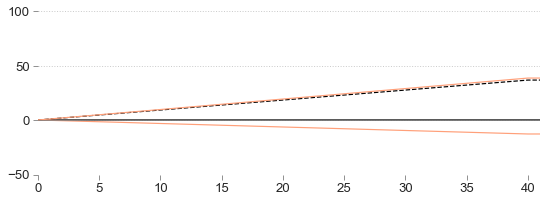

,"impact at year = 41, kg CO2-Eq"
a_a_2126_dg_init,0.171
a_b_2126_dg0,36.851
a_c_2126_sg1,38.704
a_d_2126_sg2,-12.731


In [474]:
# Define the simulation step, plot as curves:
step = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_igu = ['dg_init', 'sg', "dg0"]
conv_factor = 0.001

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

step_1
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


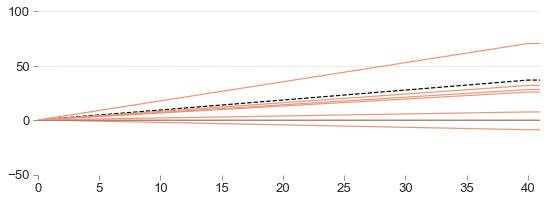

,"impact at year = 41, kg CO2-Eq"
a_a_2126_dg_init,0.171
a_b_2126_dg0,36.851
a_e_2126_dg1,70.457
a_f_2126_dg2,28.137
a_g_2126_dg3,31.937
a_h_2126_dg4,-8.819
a_i_2126_dg5,7.537
a_j_2126_dg6,25.817


In [475]:
ls_igu = ['dg', "dg0"]

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

step_1
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


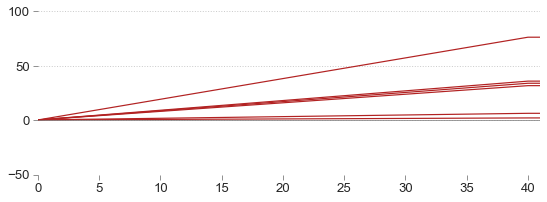

,"impact at year = 41, kg CO2-Eq"
a_k_2126_tg1,76.283
a_l_2126_tg2,35.883
a_m_2126_tg3,31.723
a_n_2126_tg4,2.043
a_o_2126_tg5,6.283
a_p_2126_tg6,33.923


In [476]:
ls_igu = ['tg']

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

Another kind of plot:

step_1
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
a_a_2126_dg_init,0.171
a_b_2126_dg0,36.851
a_c_2126_sg1,38.704
a_d_2126_sg2,-12.731
a_e_2126_dg1,70.457
a_f_2126_dg2,28.137
a_g_2126_dg3,31.937
a_h_2126_dg4,-8.819
a_i_2126_dg5,7.537
a_j_2126_dg6,25.817


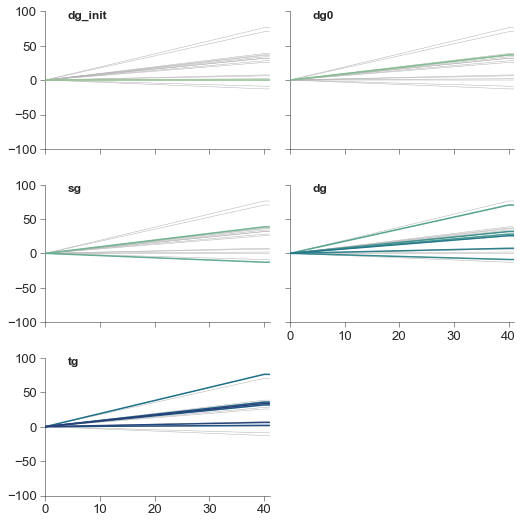

In [526]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_1"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 2: Different Glazing Types, with Interior Shading Devices, Fan Coil Chiller w/ Boiler

step_2
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
b_a_2126_dg_init_int,8.722
b_b_2126_dg0_int,28.082
b_c_2126_sg1_int,17.575
b_d_2126_sg2_int,-2.309
b_e_2126_dg1_int,67.768
b_f_2126_dg2_int,39.528
b_g_2126_dg3_int,43.528
b_h_2126_dg4_int,5.568
b_i_2126_dg5_int,22.608
b_j_2126_dg6_int,39.289


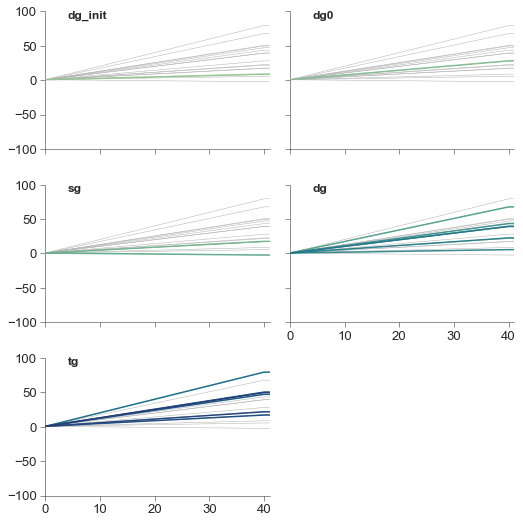

In [527]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_2"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 3: Different Glazing Types, w/ Exterior Shading Devices, Fan Coil Chiller w/ Boiler

step_3
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
c_a_2126_dg_init_tc,-40.594
c_b_2126_dg0_tc,-25.434
c_c_2126_sg1_tc,-24.541
c_d_2126_sg2_tc,-46.261
c_e_2126_dg1_tc,4.688
c_f_2126_dg2_tc,-14.789
c_g_2126_dg3_tc,-11.510
c_h_2126_dg4_tc,-31.428
c_i_2126_dg5_tc,-23.309
c_j_2126_dg6_tc,-14.468


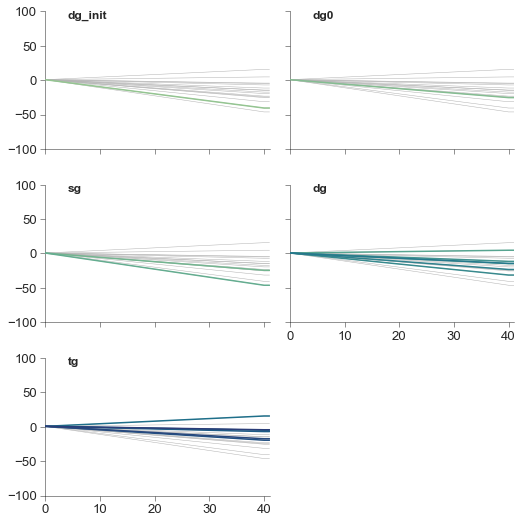

In [528]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_3"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis Steps 1-3

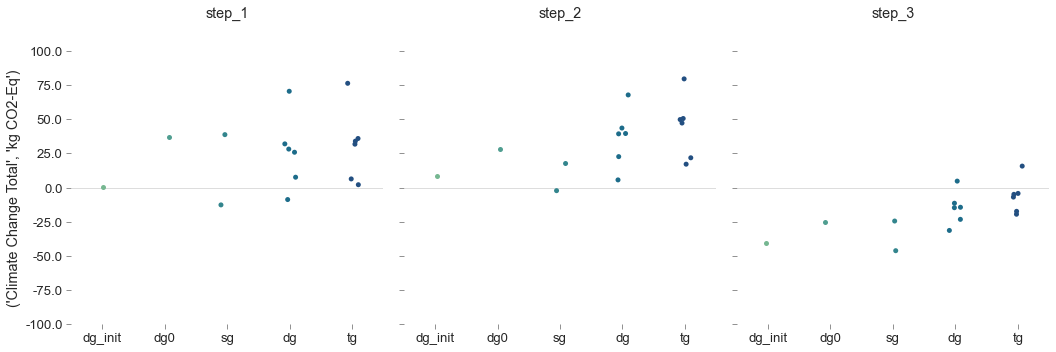

In [529]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_1', 'step_2', 'step_3']].xs(
    ic, axis=1, level=3, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=("Climate Change Total", "kg CO2-Eq"),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)
    
(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

## Steps 4-7: HVAC System Optimisation, VAV and VRF

### Step 4: Efficient VAV HVAC System, w/o Shading Devices

step_4
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
d_a_2126_dg_init_vav,0.171
d_b_2126_dg0_vav,40.971
d_c_2126_sg1_vav,79.344
d_d_2126_sg2_vav,-10.411
d_e_2126_dg1_vav,41.537
d_f_2126_dg2_vav,-3.660
d_g_2126_dg3_vav,-1.902
d_h_2126_dg4_vav,-50.579
d_i_2126_dg5_vav,-31.219
d_j_2126_dg6_vav,-9.099


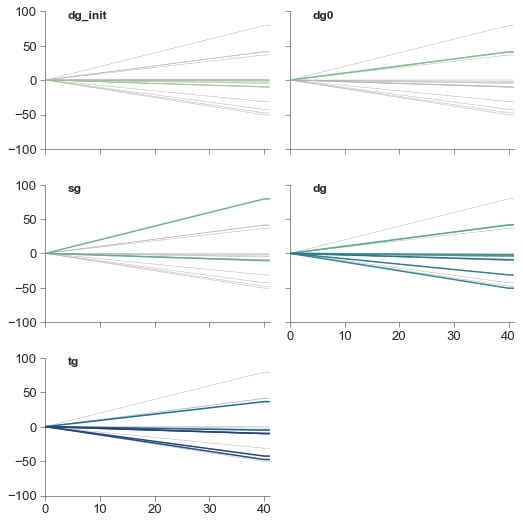

In [530]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_4"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 5: Efficient VAV HVAC System, with interior shading devices

step_5
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
e_a_2126_dg_init_vav_int,3.002
e_b_2126_dg0_vav_int,19.442
e_c_2126_sg1_vav_int,38.655
e_d_2126_sg2_vav_int,-2.907
e_e_2126_dg1_vav_int,21.208
e_f_2126_dg2_vav_int,-5.072
e_g_2126_dg3_vav_int,-3.873
e_h_2126_dg4_vav_int,-41.348
e_i_2126_dg5_vav_int,-23.909
e_j_2126_dg6_vav_int,-7.670


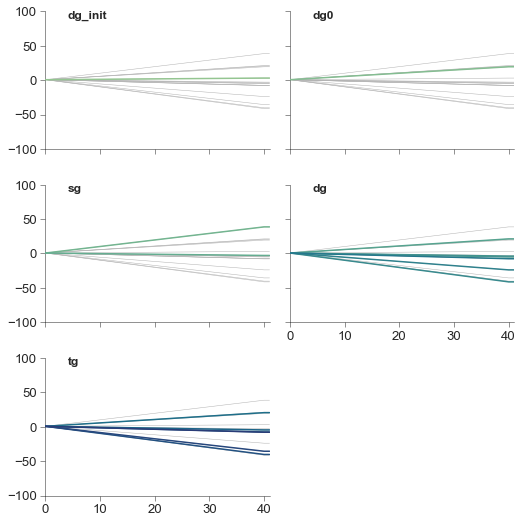

In [531]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_5"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 6: Efficient VRF HVAC System, w/o Shading Devices

step_6
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
f_a_2126_dg_init_vrf,0.171
f_b_2126_dg0_vrf,16.291
f_c_2126_sg1_vrf,41.824
f_d_2126_sg2_vrf,-1.055
f_e_2126_dg1_vrf,16.737
f_f_2126_dg2_vrf,-4.860
f_g_2126_dg3_vrf,-4.020
f_h_2126_dg4_vrf,-24.059
f_i_2126_dg5_vrf,-16.379
f_j_2126_dg6_vrf,-7.099


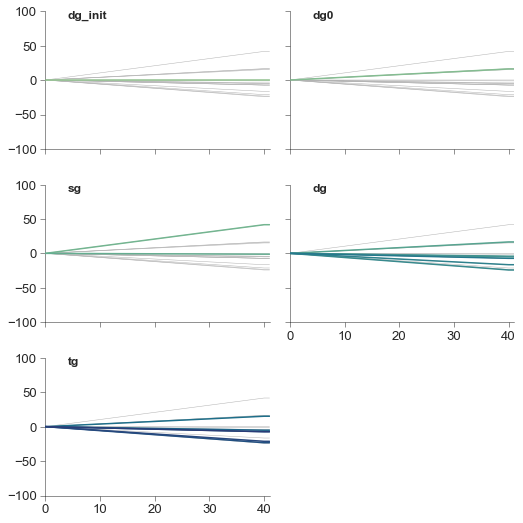

In [532]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_6"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 7: Efficient VRF HVAC System, with interior shading devices

step_7
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
g_a_2126_dg_init_vrf_int,8.362
g_b_2126_dg0_vrf_int,14.642
g_c_2126_sg1_vrf_int,32.295
g_d_2126_sg2_vrf_int,7.815
g_e_2126_dg1_vrf_int,18.648
g_f_2126_dg2_vrf_int,5.168
g_g_2126_dg3_vrf_int,6.168
g_h_2126_dg4_vrf_int,-12.909
g_i_2126_dg5_vrf_int,-4.113
g_j_2126_dg6_vrf_int,4.249


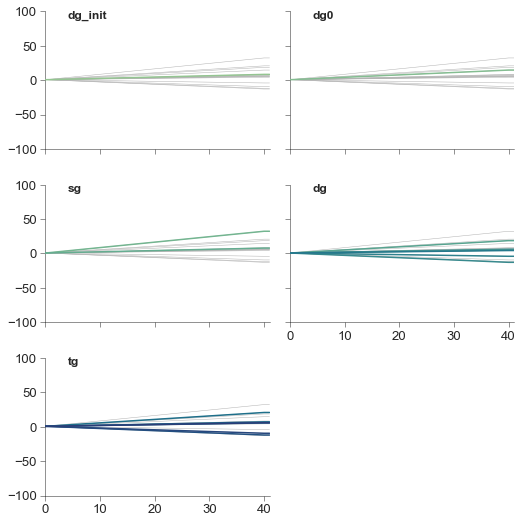

In [533]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_7"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to HVAC System

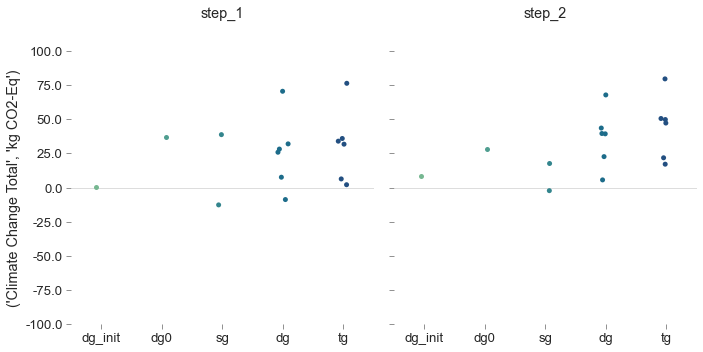

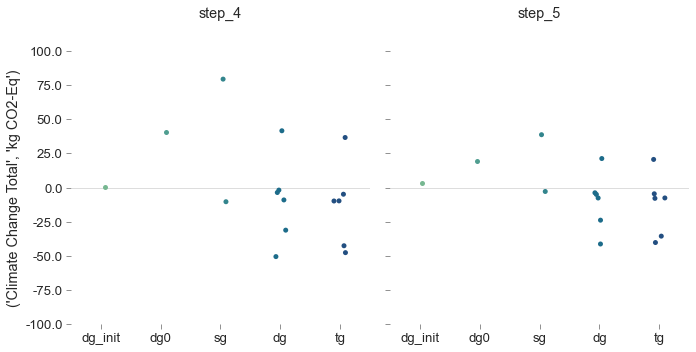

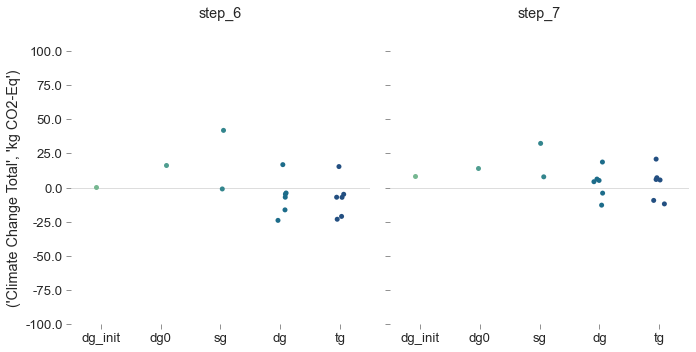

In [534]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for i, j in [('step_1', 'step_2'), 
             ('step_4', 'step_5'), 
             ('step_6', 'step_7')]:
    
    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[i, j]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette="crest", height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )
    
    plt.show()

## Steps 8: Reduction of the Window-to-Wall Ratio

### 75% of the Initial WtW Ratio

step_8
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
h_a_2126_dg_init_wtw,-26.385
h_b_2126_dg0_wtw,8.011
h_c_2126_dg4_wtw,-61.179
h_d_2126_dg5_wtw,-46.619
h_e_2126_dg6_wtw,-30.179
h_f_2126_tg4_wtw,-57.433
h_g_2126_tg5_wtw,-54.233
h_h_2126_tg6_wtw,-30.153


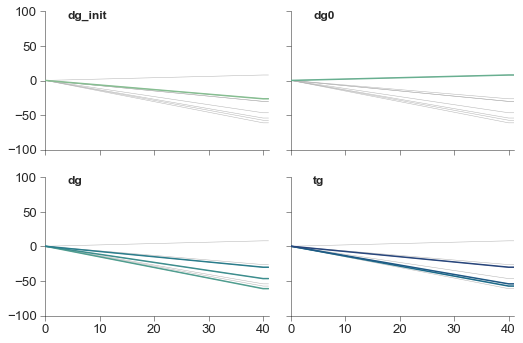

In [535]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_8"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to WtW Ratio

Compare step 4 and 8. Difference comes from the window-to-wall ratio, 100% and 75% respectively.

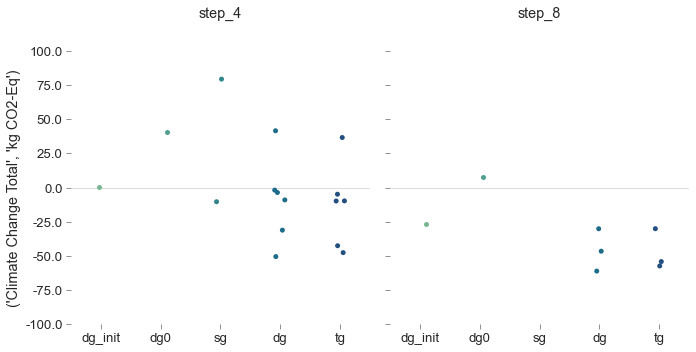

In [536]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_4', 'step_8']].xs(
    ic, axis=1, level=3, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=("Climate Change Total", "kg CO2-Eq"),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

## Steps 9: High-Tech Glazing Units

step_9
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
"(i_a_2126_dg_init_vav_int, dg_init)",3.002
"(i_b_2126_dg5k, dg)",-19.824
"(i_c_2126_tg5k, tg)",-33.552
"(i_d_2126_tg5x, tg)",-32.364
"(i_e_2126_ccf, ccf)",-74.911
"(i_f_2126_dg_vacuum, dg_vacuum)",-18.103
"(i_g_2126_dg_smart, dg_smart)",-71.935
"(i_h_2126_dsf_min, dsf)",-41.019
"(i_i_2126_dsf_mean, dsf)",-35.739
"(i_j_2126_dsf_max, dsf)",-30.979


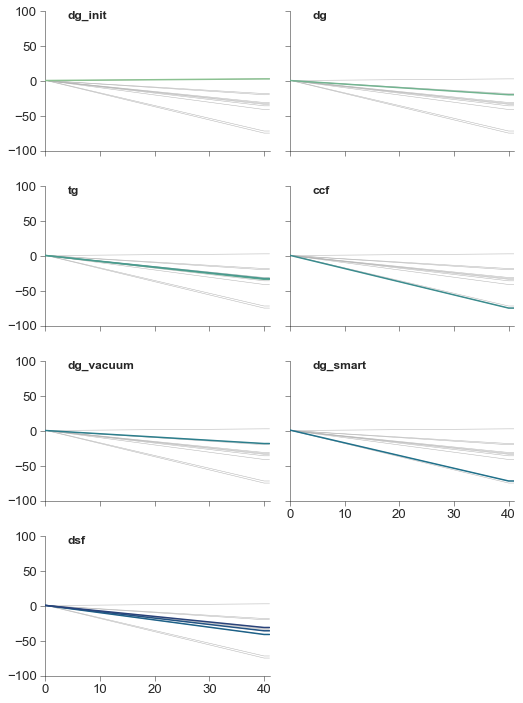

In [518]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_9"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis of High-Tech Glazing Units

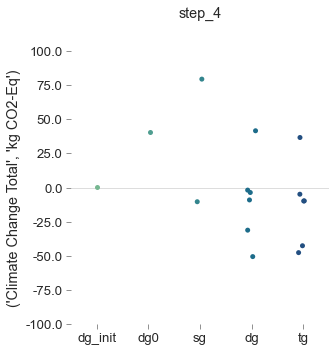

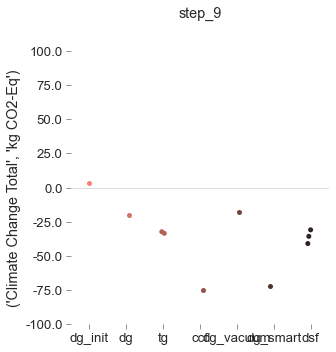

In [519]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for step in ['step_4', 'step_9']:
    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[step]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()
    
    if step == 'step_4':
        p = "crest"
    else:
        p = "dark:salmon_r"

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette=p, height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )

    plt.show()

## Steps 10-11: Lifestyles

"Americanisation"

step_10
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
"(j_a_2124_dg_init, dg_init)",36.931
"(j_b_2124_dg0, dg0)",85.411
"(j_c_2124_dg4, dg)",-14.979
"(j_d_2124_dg5, dg)",1.897
"(j_e_2124_dg6, dg)",21.817
"(j_f_2124_tg4, tg)",-14.233
"(j_g_2124_tg5, tg)",-9.313
"(j_h_2124_tg6, tg)",19.923


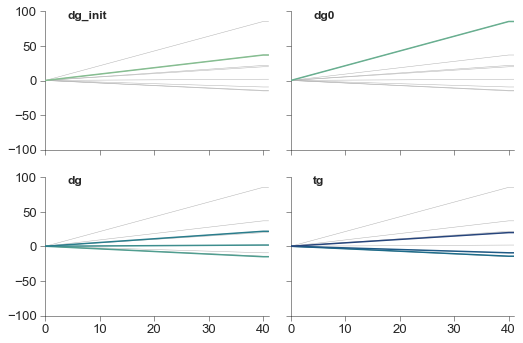

In [520]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_10"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

"Sufficiency"

step_11
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
"(k_a_1927_dg_init_ext, dg_init)",-91.434
"(k_b_1927_dg0_ext, dg0)",-75.874
"(k_c_1927_dg4_ext, dg)",-96.948
"(k_d_1927_dg5_ext, dg)",-88.988
"(k_e_1927_dg6_ext, dg)",-79.947
"(k_f_1927_tg4_ext, tg)",-88.361
"(k_g_1927_tg5_ext, tg)",-86.481
"(k_h_1927_tg6_ext, tg)",-74.041


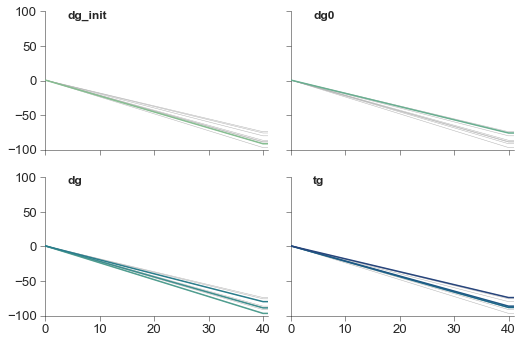

In [521]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_11"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

## Steps 12-13: Internal Gains

step_12
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
"(l_a_2126_dg_init_intgain, dg_init)",86.842
"(l_b_2126_dg0_intgain, dg0)",105.082
"(l_c_2126_dg4_intgain, dg)",49.448
"(l_d_2126_dg5_intgain, dg)",66.928
"(l_e_2126_dg6_intgain, dg)",83.969
"(l_f_2126_tg4_intgain, tg)",52.875
"(l_g_2126_tg5_intgain, tg)",57.435
"(l_h_2126_tg6_intgain, tg)",85.875


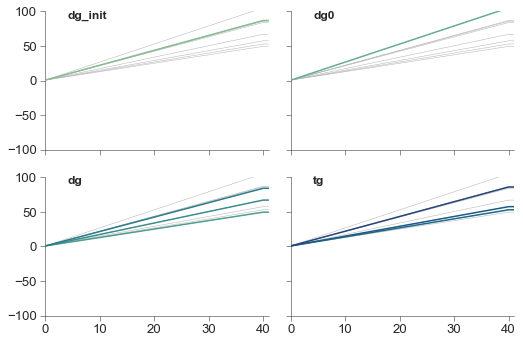

In [522]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_12"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

step_13
Climate Change Total
Unit is: kg CO2-Eq . With conversion factor: 0.001


,"impact at year = 41, points"
m_a_2126_dg_init_intgain,-66.354
m_b_2126_dg0_intgain,-52.474
m_c_2126_dg4_intgain,-117.908
m_d_2126_dg5_intgain,-100.908
m_e_2126_dg6_intgain,-85.187
m_f_2126_tg4_intgain,-119.441
m_g_2126_tg5_intgain,-114.801
m_h_2126_tg6_intgain,-87.281


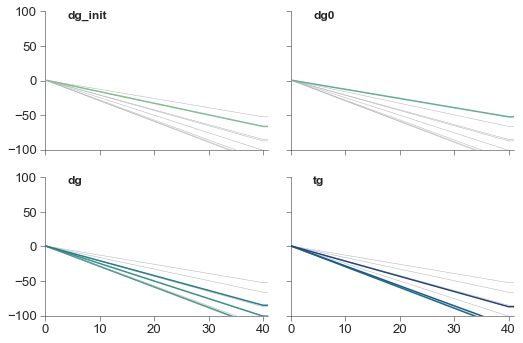

In [537]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_13"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

# Energy Mix and Fully Electrified HVAC System: Sensitivity Analysis

In [ ]:
# List of activities to change, in this case electricity markets:
locations = ["FR", "DE", "PL", "NL", "CH"]

act_name = "market for electricity, low voltage"

elec_market = [('ecoinvent 3.7 cut-off', act['code'])
              for act in eicutdb.search(act_name, limit=200)
              for location in locations
              if act_name in act['name'] and location in act['location']
              and "US-FRCC" not in act['location']
              and "US-SERC" not in act['location']
             ]

# Remove "market for electricity, low voltage, label-certified" for CH:
elec_market.pop(5)

elec_market

In [ ]:
# Printing the exchanges
print('My activity is:\n', use_bldg_w_cw, '\n-------\nAnd its exchanges:\n-------')

for i in list(use_bldg_w_cw.exchanges()):
    print(i['type'])
    print(i)
    print(i['input'])
    print('-------')

In [ ]:
exc_elec = list(use_bldg_w_cw.exchanges())[0]
exc_elec

In [ ]:
# LCA according to energy mix:

# DF to save results:
df_results = pd.DataFrame()

n = 0

# to name the calculation steps according to location for elec mix:
ls_loc = []
for i in range(len(elec_market)):
    my_act_elec = Database('ecoinvent 3.7 cut-off').get(elec_market[i][1])
    ls_loc.append(my_act_elec['location'])

# Make a copy of the activity, substitute the background process
# save and calculate:
for m in elec_market:
    use_bldg_w_cw_copy = use_bldg_w_cw.copy()
    exc_elec['input'] = m
    exc_elec.save()
    step = "step_6_"+ls_loc[n]
    n += 1
    for act in [prod_cw, use_bldg_w_cw_copy, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step6, act, 1)
        df_energymix_results = ls_to_df_mlca_full(
            step, ls, act, df_results
        )

In [ ]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_energymix_results.loc[step].xs(ic, axis=1,
                                      level=1, drop_level=False
                                      )

In [ ]:
np.mean([(i/be_cw_elec_result) for i in cw_elec_results])

In [ ]:
pd.DataFrame(cw_elec_results).describe()

In [ ]:
plt.boxplot(cw_elec_results)
plt.ylabel(methods[('IPCC 2013', 'climate change', 'GWP 100a')]['unit'])
plt.xlabel('El Production')